<a href="https://colab.research.google.com/github/theclosedbook/GAN/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing Libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
#Print Tf Version
print(tf.__version__)

2.15.0


In [3]:
## Loading and preprocessing the dataset
(X_train,y_train),(_,_) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
#Shape of X_train
X_train.shape

(60000, 28, 28)

In [5]:
#Shape of y_train
y_train.shape

(60000,)

25515
9


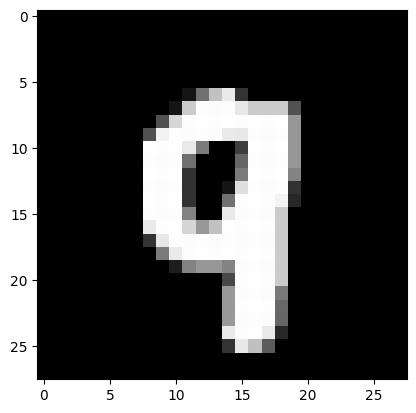

In [6]:
# To Visualize X_train and y_train
i = np.random.randint(0,60000)
print(i)
print(y_train[i])
plt.imshow(X_train[i],cmap='gray')

In [7]:
# Reshaping X_train
X_train = X_train.reshape(X_train.shape[0],28,28,1).astype('float32')

In [8]:
#Shape Of the resized X_train
X_train.shape

(60000, 28, 28, 1)

In [9]:
#Min and Max Value (Normalization Needed)
X_train[0].min(),X_train[0].max()

(0.0, 255.0)

In [10]:
X_train = (X_train - 127.5) / 127.5

In [11]:
X_train[0].min(),X_train[0].max()

(-1.0, 1.0)

In [12]:
buffer_size = 60000
batch_size = 256

In [13]:
#Coneverting from np to tensors
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [14]:
#X_train info after converting into tensor
X_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

##Building Generator

In [43]:
# 100 -> 12544
def build_generator():
  network = tf.keras.Sequential()

  network.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding = 'same', use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(filters = 1, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias=True, activation='tanh'))

  network.summary()

  return network


In [42]:
# Summary of the generator
generator = build_generator()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_7 (Bat  (None, 12544)             50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_7 (Conv2D  (None, 7, 7, 128)         819200    
 Transpose)                                                      
                                                                 
 batch_normalization_8 (Bat  (None, 7, 7, 128)        

In [17]:
# Input of the generator
generator.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_input')>

In [18]:
# Random Noise
noise = tf.random.normal([1,100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.3431412 ,  1.6391948 , -0.8682506 ,  0.07210752,  0.78014684,
         1.1590302 , -0.93786216, -1.7884201 , -0.05368365,  1.7204796 ,
        -0.54756653,  1.6785021 , -0.6933195 , -1.8991225 ,  2.9333298 ,
         0.3211105 ,  0.99299765, -1.1864781 ,  0.45131874, -0.57609135,
        -0.9385113 ,  2.318341  , -0.70786786, -0.47652644, -0.5739888 ,
         1.1937501 ,  0.29666698,  1.1043677 ,  0.8987782 ,  1.8729247 ,
        -0.11757699,  2.4855902 , -0.4295914 , -0.75564295,  0.3226012 ,
         1.032392  ,  0.15984431, -0.37694928, -0.66412   , -0.20284952,
         0.91070014, -2.354371  , -1.0320513 , -0.43985942, -0.48366097,
        -1.321224  , -2.3134918 ,  1.289452  ,  0.4318648 ,  1.1245062 ,
        -0.17008981, -1.777139  , -0.5837938 , -0.53067493,  0.23496394,
        -0.08039777,  0.03331769,  0.52165717, -1.2138524 , -0.2370092 ,
        -0.38284284,  0.44075695,  0.28946662, -1.6770122 ,  3.0126219 ,
 

In [19]:
generated_image = generator(noise,training = False)

In [20]:
generated_image.shape

TensorShape([1, 28, 28, 1])

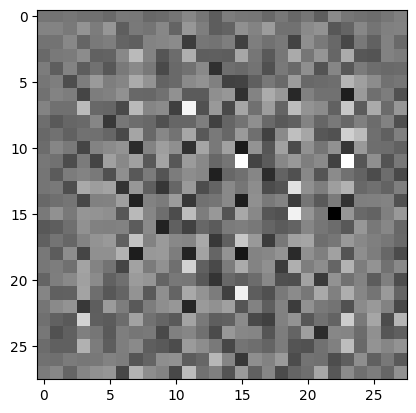

In [21]:
plt.imshow(generated_image[0,:,:,0],cmap='gray')

In [22]:
#Building the generator
def build_discriminator():
  network = tf.keras.Sequential()

  #14x14x64
  network.add(layers.Conv2D(filters=64,strides=(2,2),kernel_size=(5,5),padding = 'same', input_shape=[28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  #7x7x128
  network.add(layers.Conv2D(filters=128,strides=(2,2),kernel_size=(5,5),padding = 'same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()

  return network

In [23]:
# Discriminator Summary
discriminator = build_discriminator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [24]:
# input of the discriminator
discriminator.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_input')>

In [25]:
#Check for the noise i.e generated image
discriminator(generated_image,training = False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00134828]], dtype=float32)>

In [26]:
# Checking the probability of the answer (closer to 1 = real)
tf.sigmoid(0.00039913)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5000998>

## Error Calculation

In [27]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [28]:
# Building discriminator loss

def discriminator_loss(expected_output,fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss = real_loss + fake_loss

  return total_loss


In [29]:
# Building the Generator loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

In [30]:
# generator_optimizer
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

In [31]:
# discriminator_optimizer
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

## Training The GAN

In [32]:
X_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [33]:
epochs = 100
noise_dimension = 100
number_of_images = 16

In [34]:
batch_size,noise_dimension

(256, 100)

In [35]:
@tf.function
def train(images):
  noise = tf.random.normal([batch_size, noise_dimension])
  #print(noise.shape)
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training = True)

    expected_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(expected_output, fake_output)

  generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [36]:
test_images = tf.random.normal([number_of_images,noise_dimension])
test_images.shape

TensorShape([16, 100])

In [37]:
def train_gan(dataset, epochs, test_images):
  for epoch in range(epochs):
    #print(epoch)
    for image_batch in dataset:
      #print(image_batch.shape)
      train(image_batch)

    print('Epoch: ', epoch + 1)
    generated_images = generator(test_images, training = False)
    fig = plt.figure(figsize = (10,10))
    for i in range(generated_images.shape[0]):
      plt.subplot(4,4,i + 1)
      plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    plt.show()

Epoch:  1


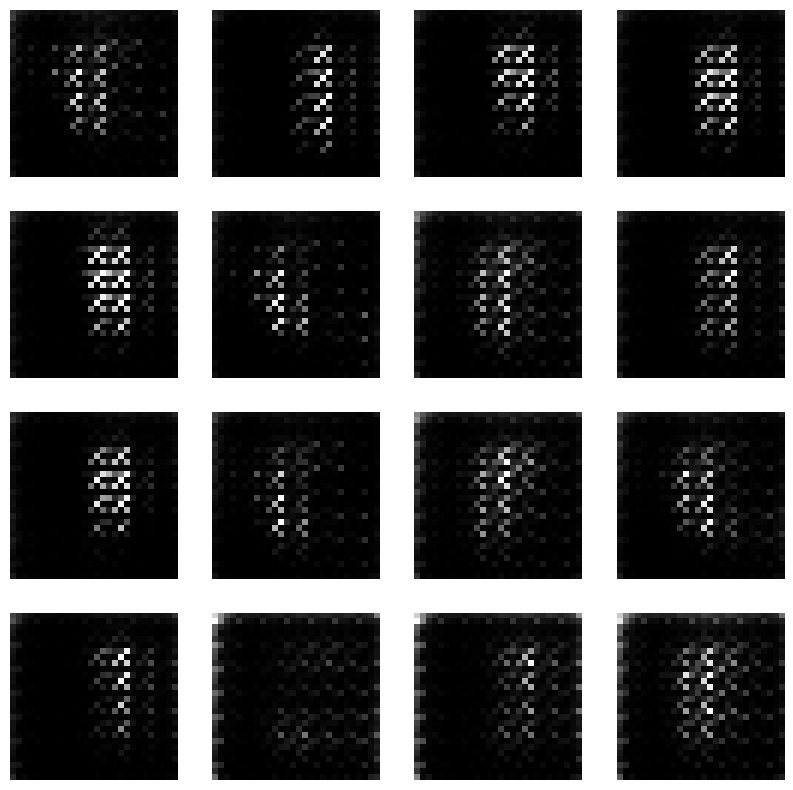

Epoch:  2


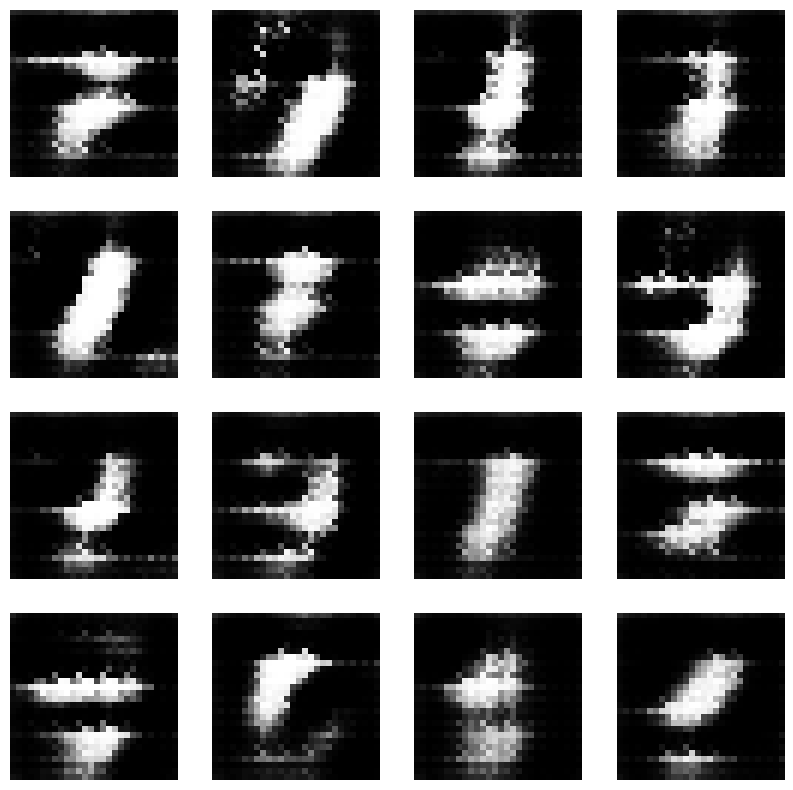

Epoch:  3


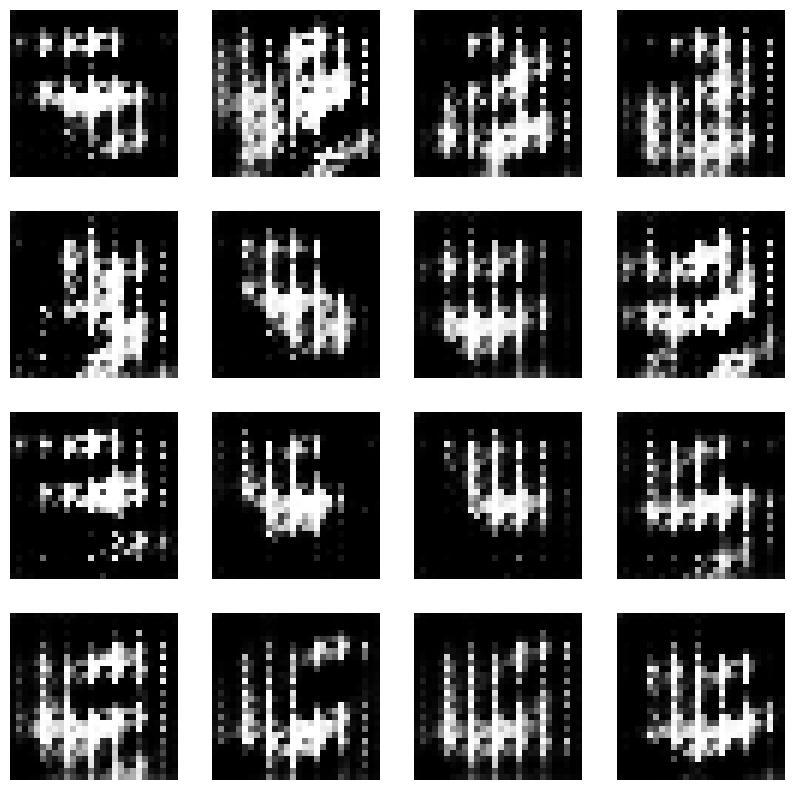

Epoch:  4


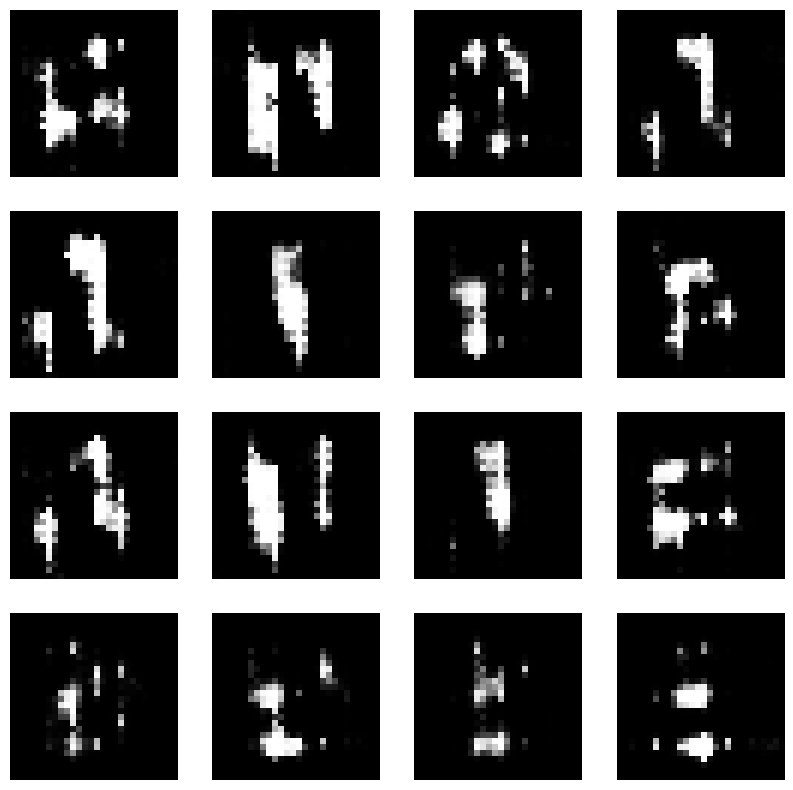

Epoch:  5


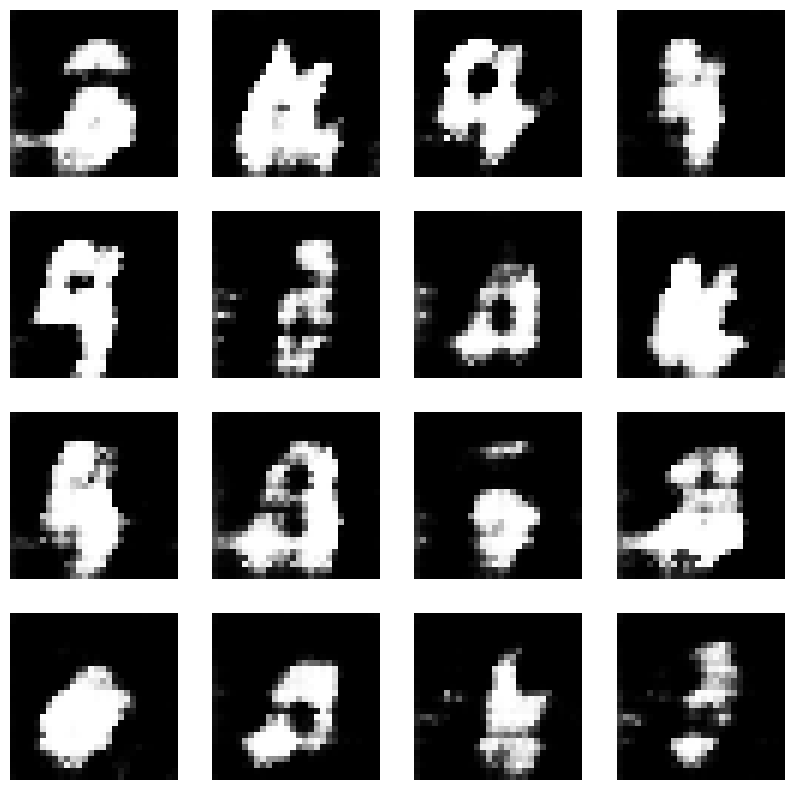

Epoch:  6


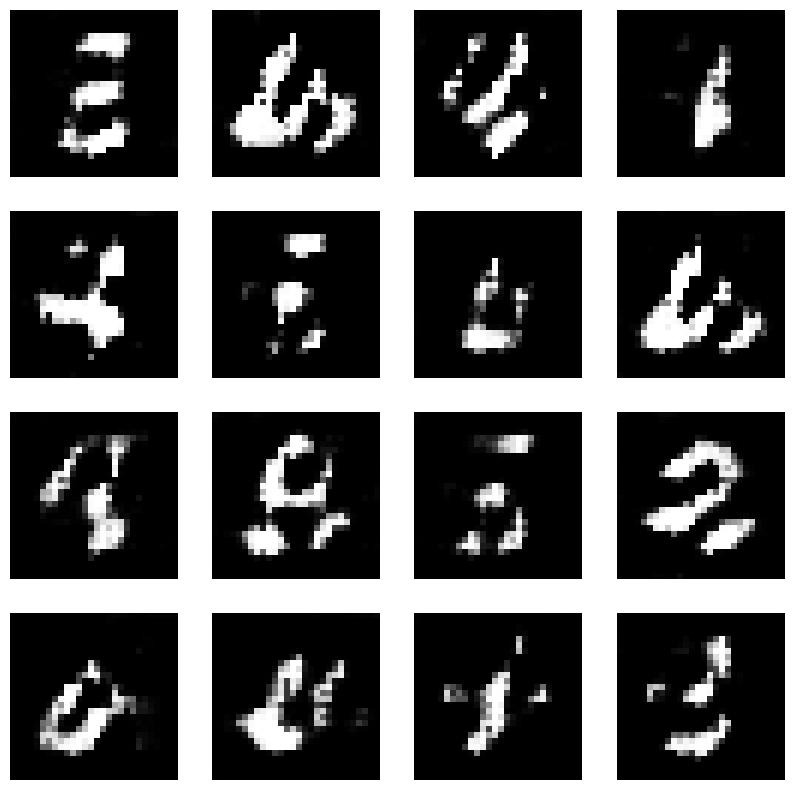

Epoch:  7


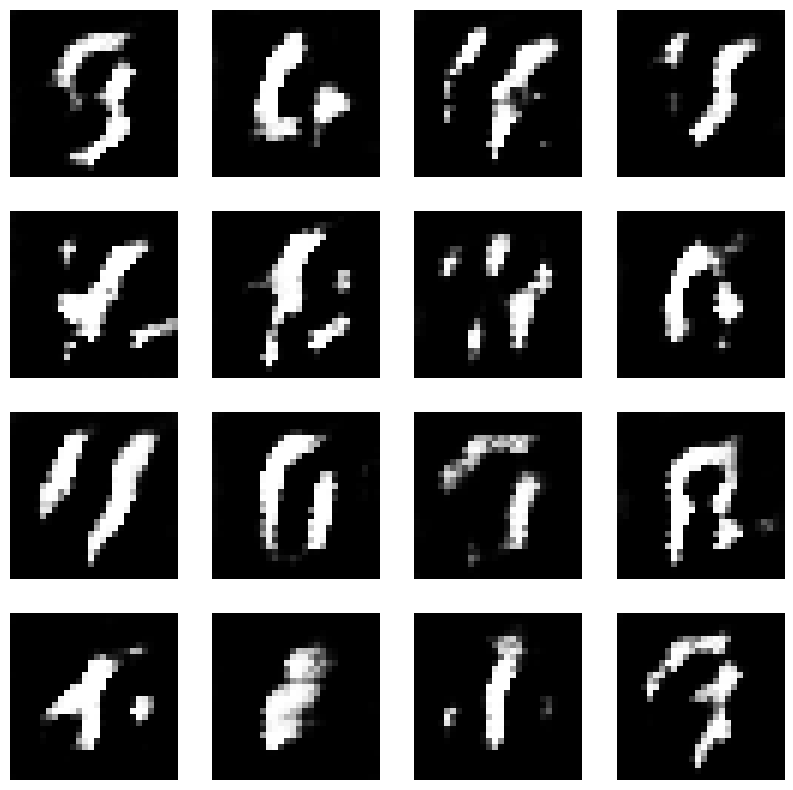

Epoch:  8


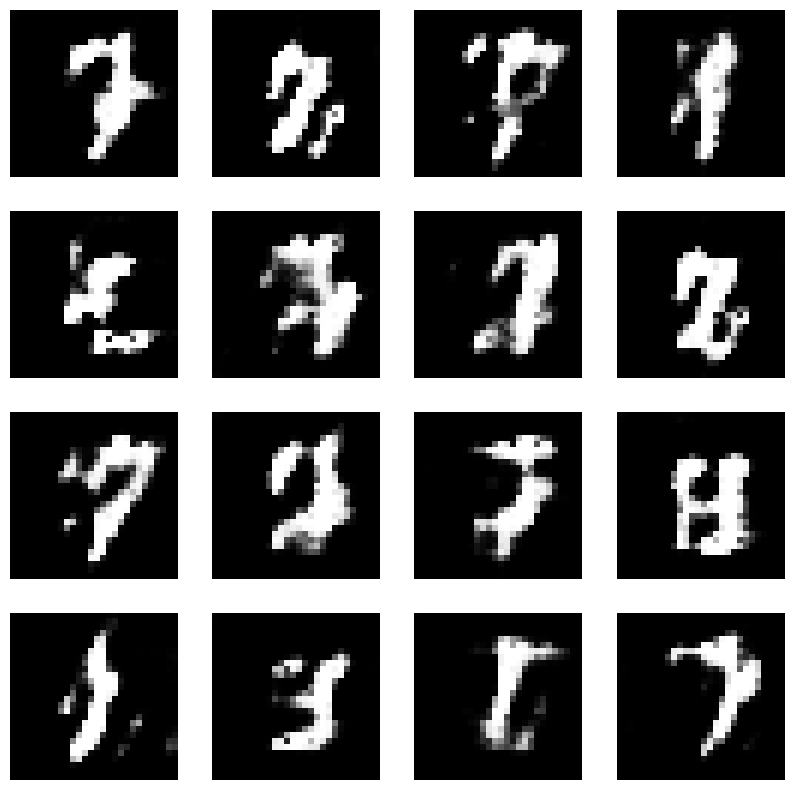

Epoch:  9


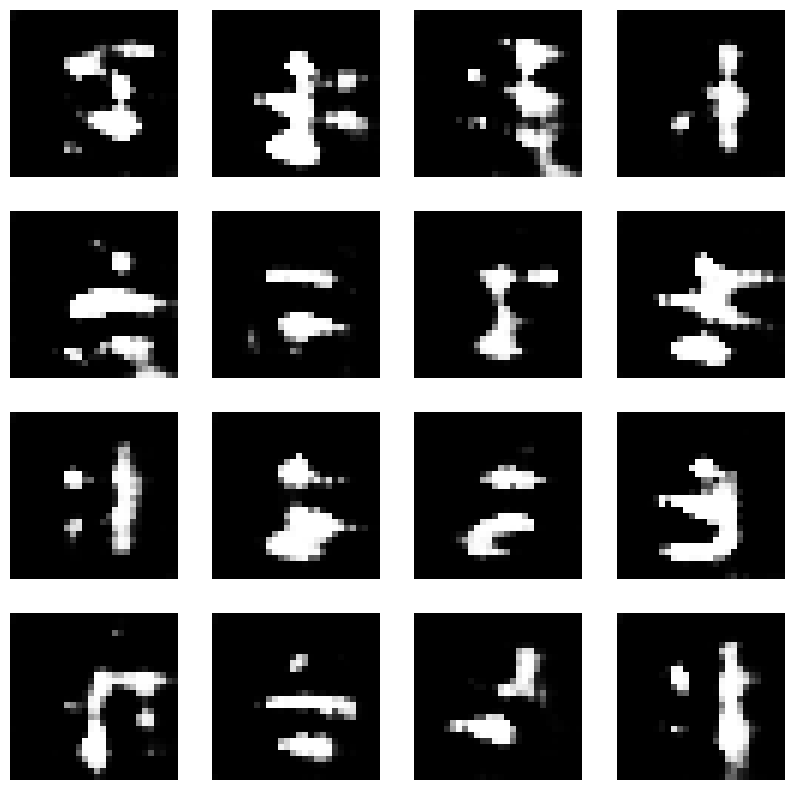

Epoch:  10


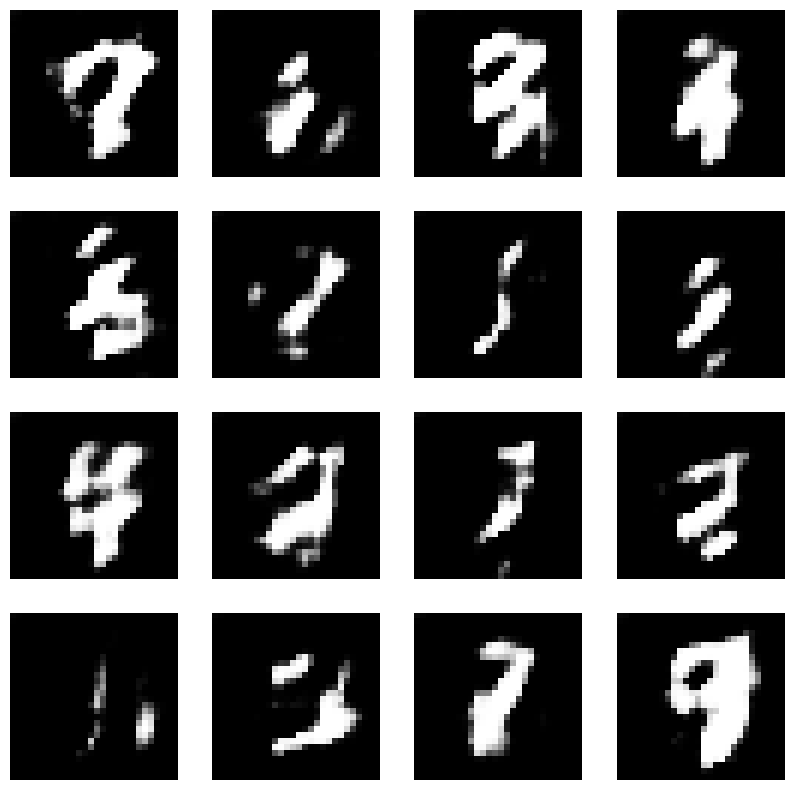

Epoch:  11


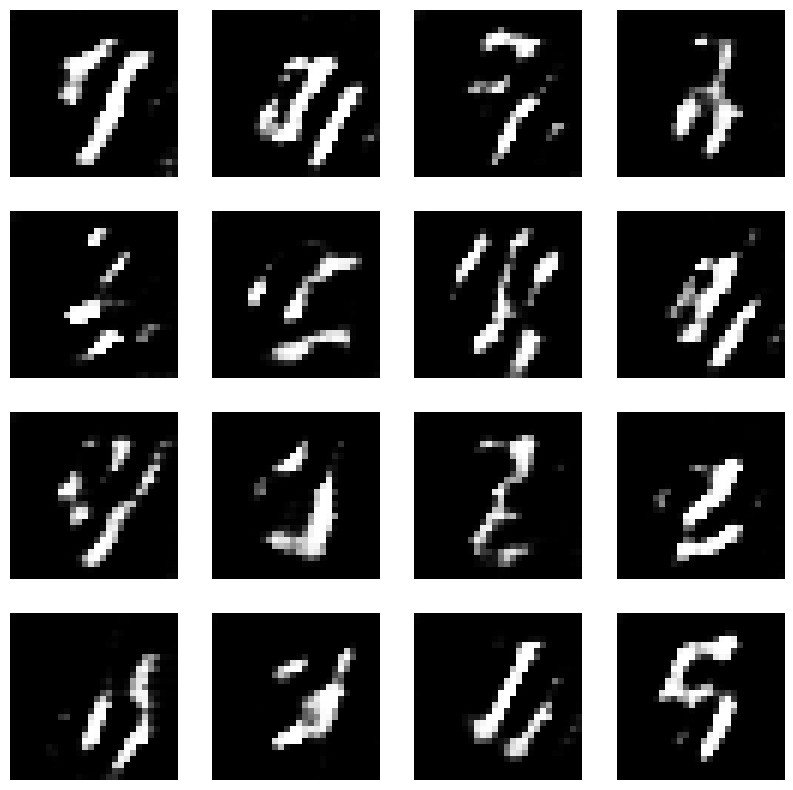

Epoch:  12


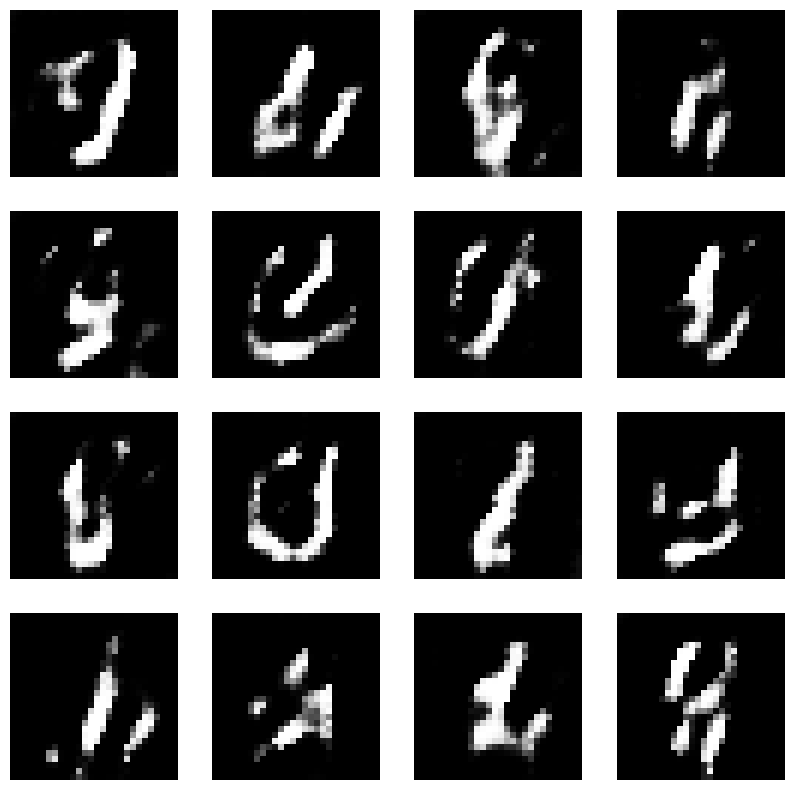

Epoch:  13


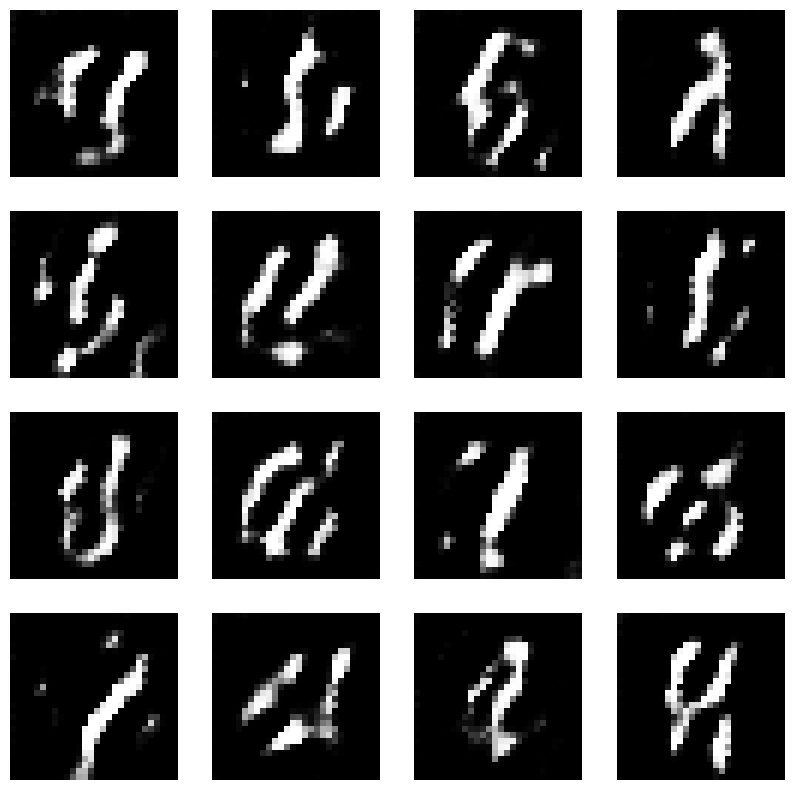

Epoch:  14


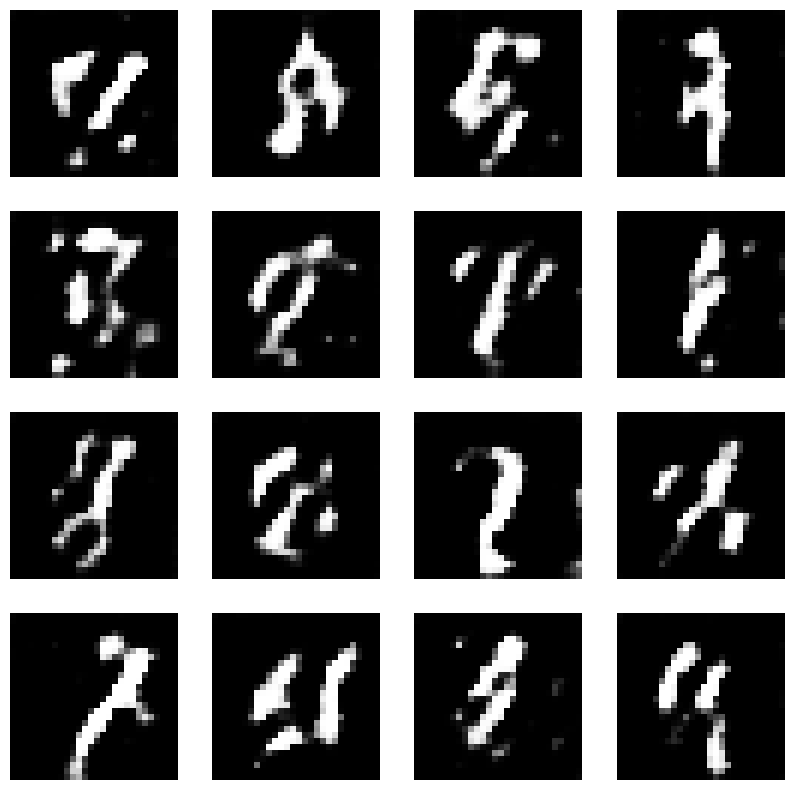

Epoch:  15


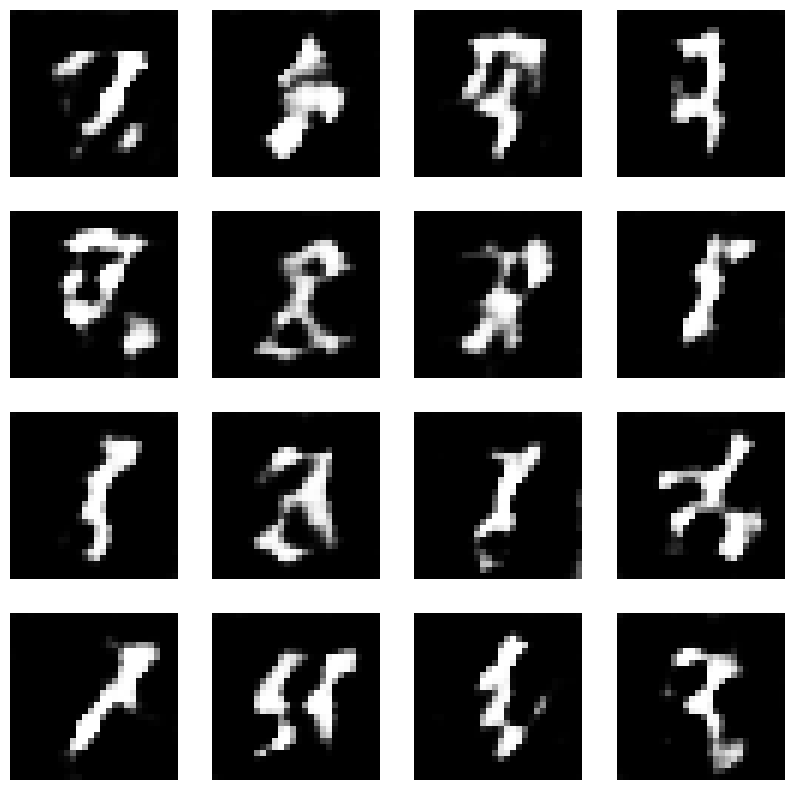

Epoch:  16


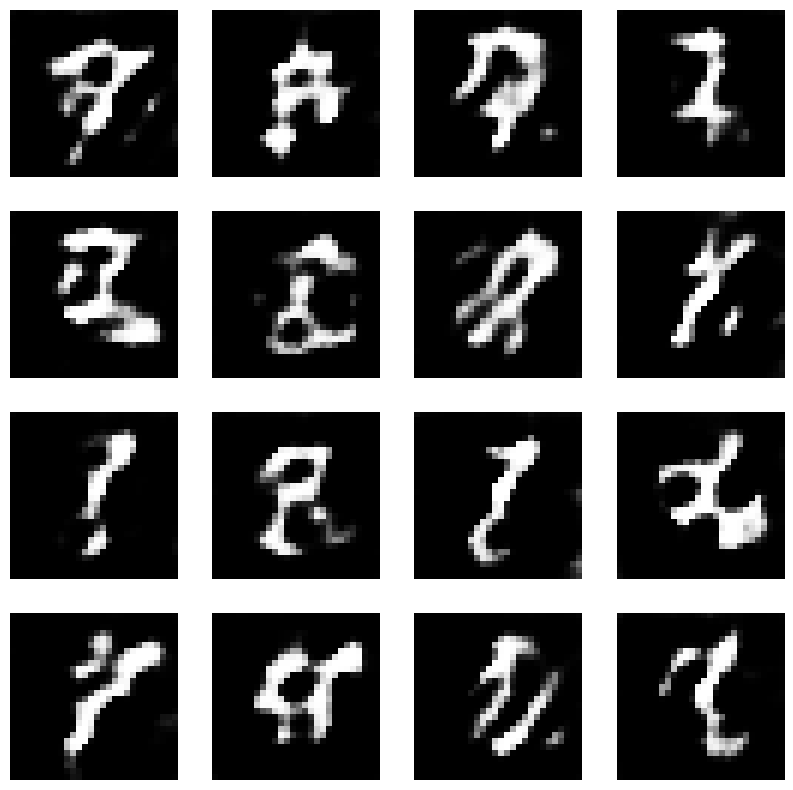

Epoch:  17


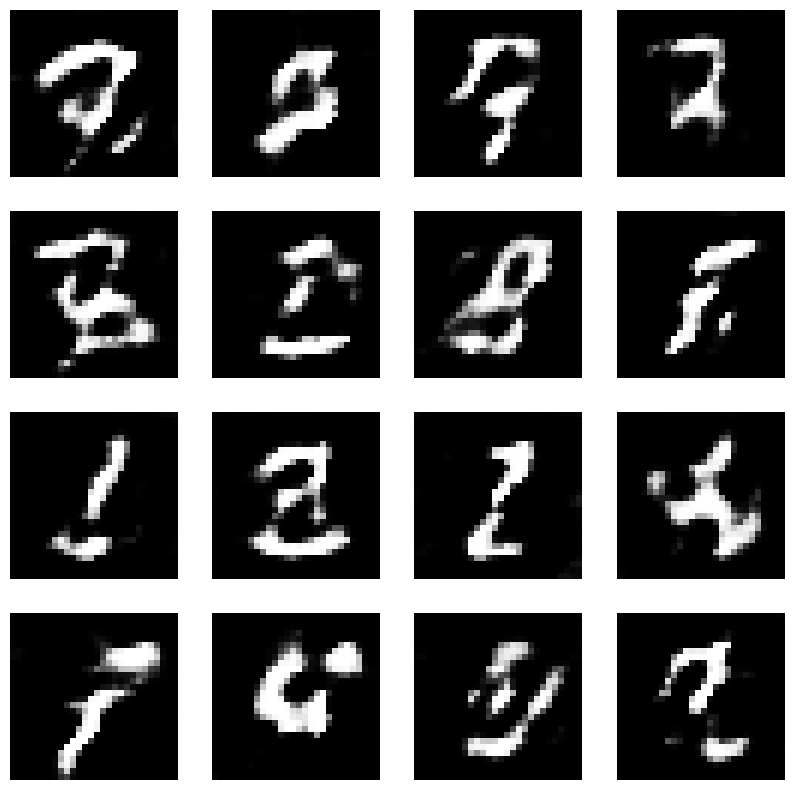

Epoch:  18


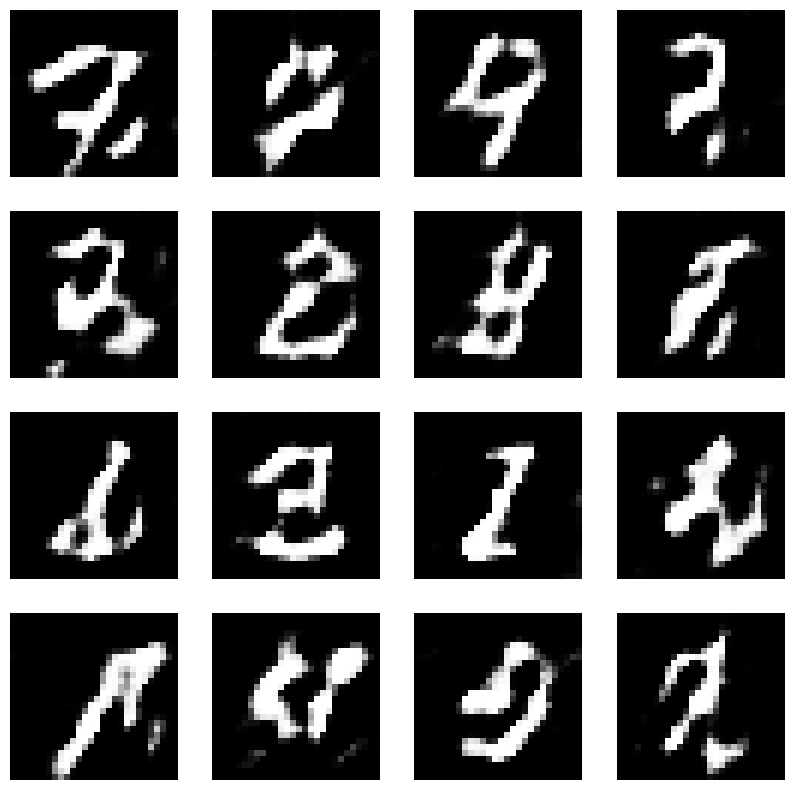

Epoch:  19


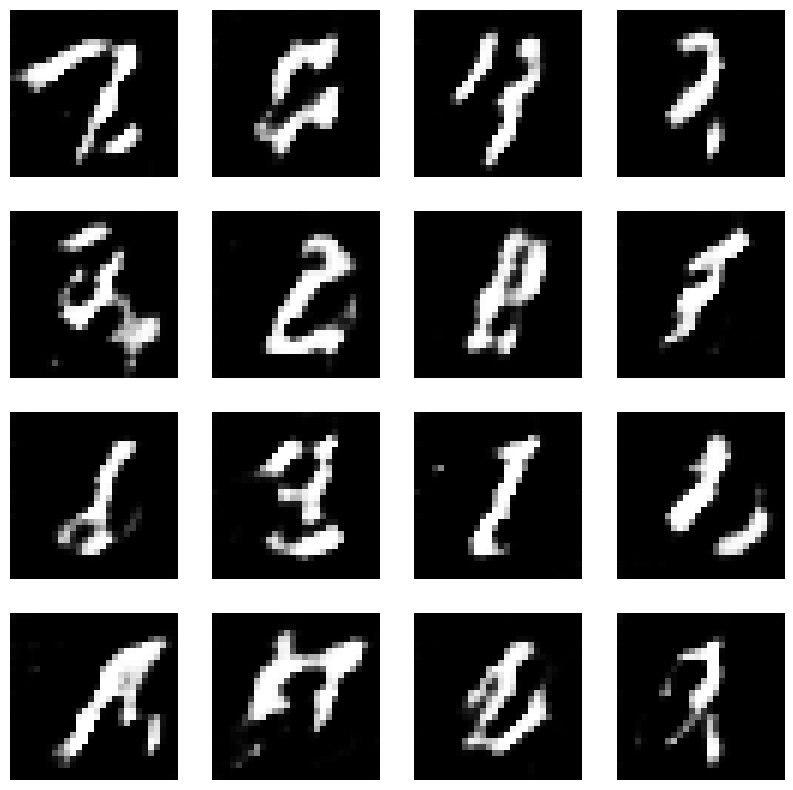

Epoch:  20


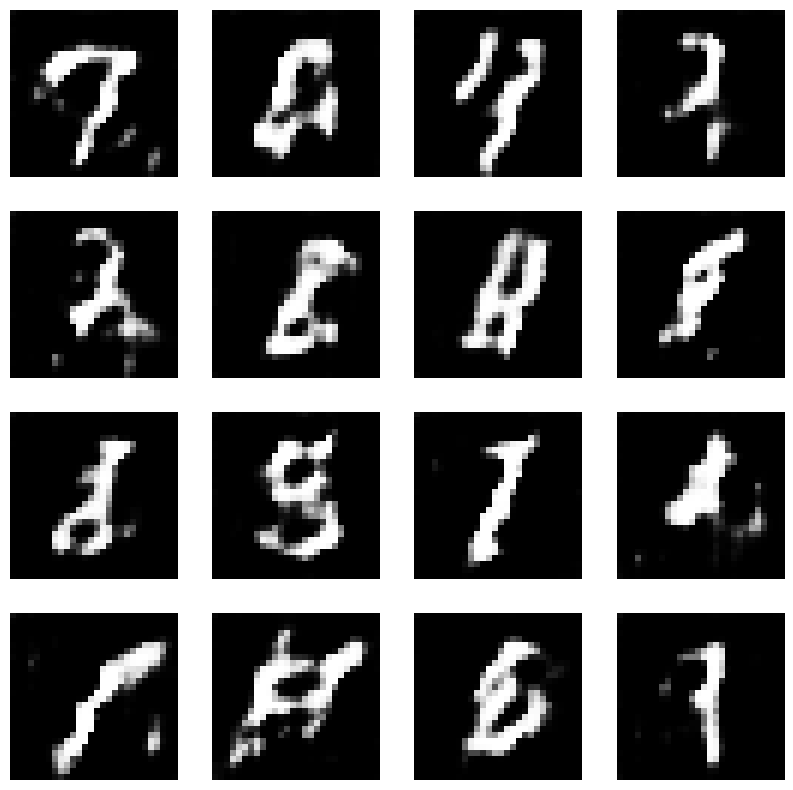

Epoch:  21


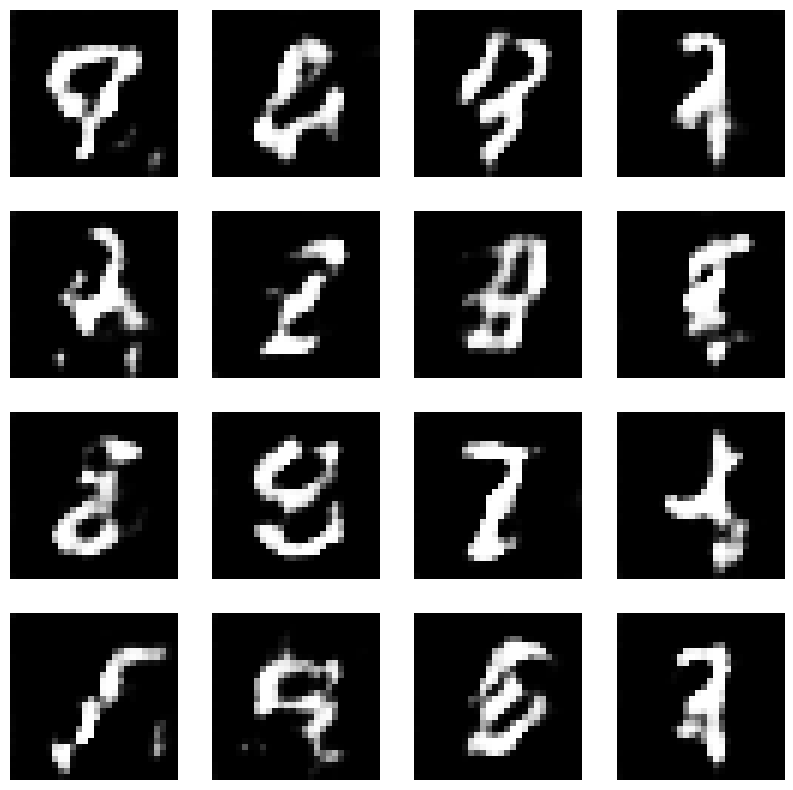

Epoch:  22


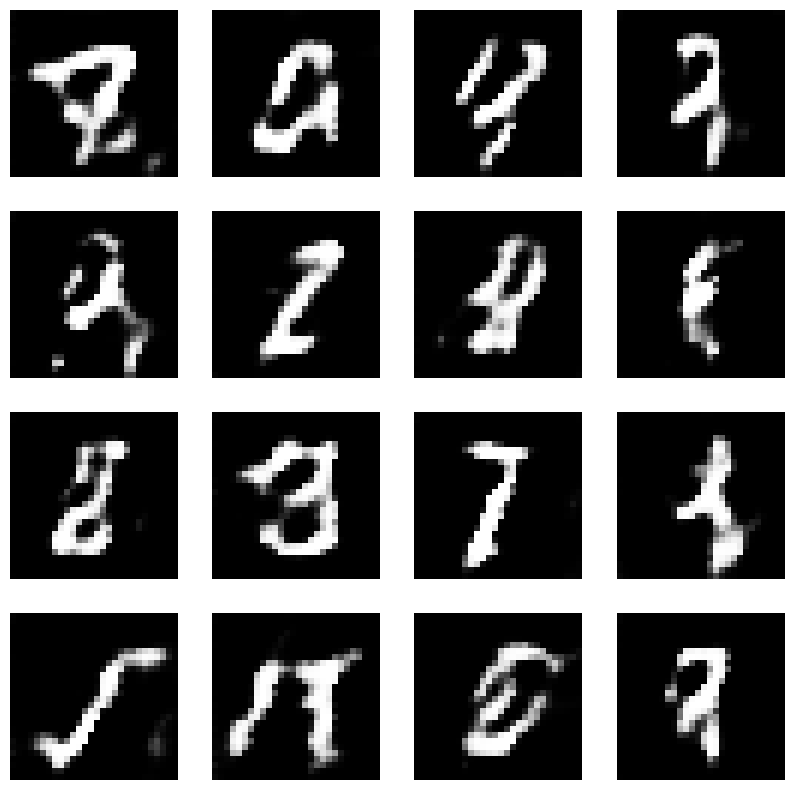

Epoch:  23


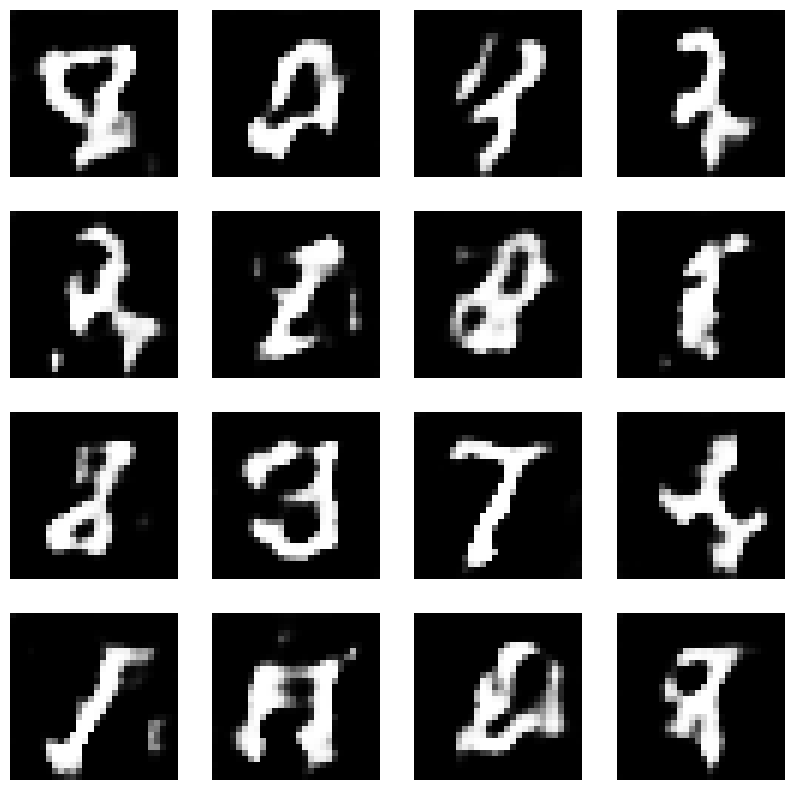

Epoch:  24


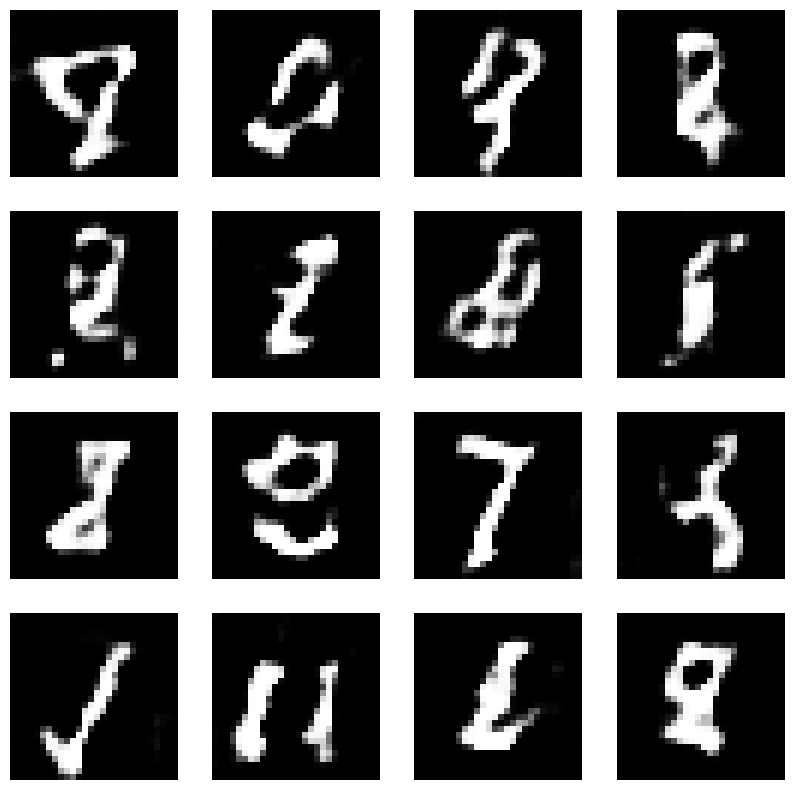

Epoch:  25


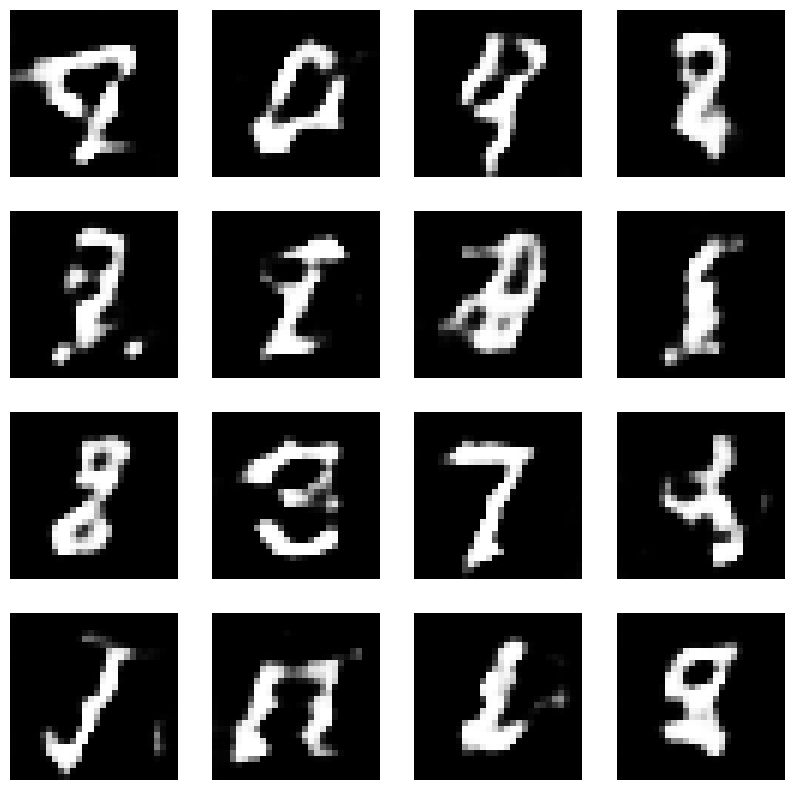

Epoch:  26


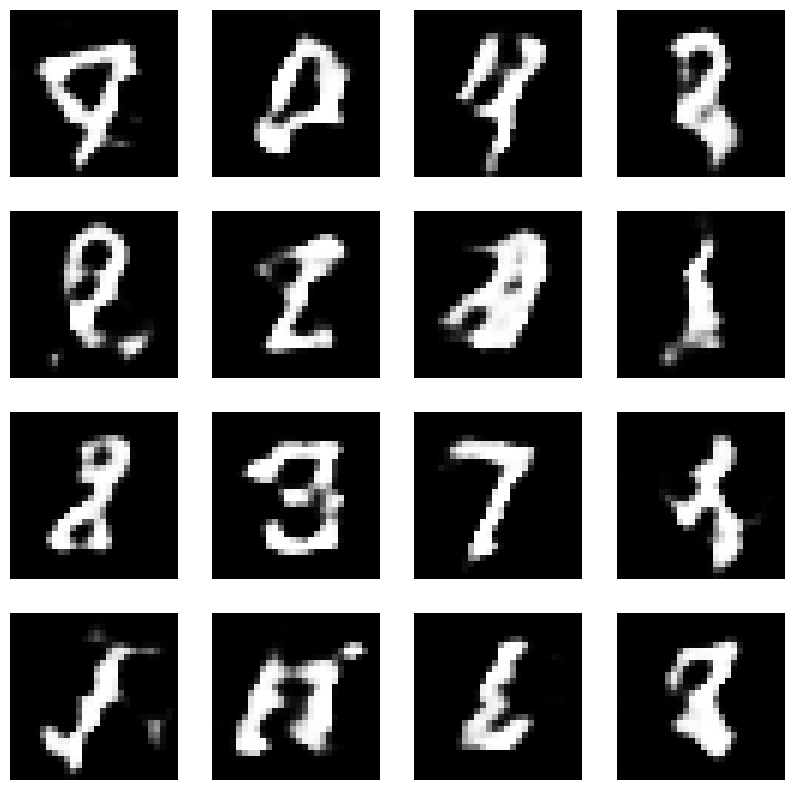

Epoch:  27


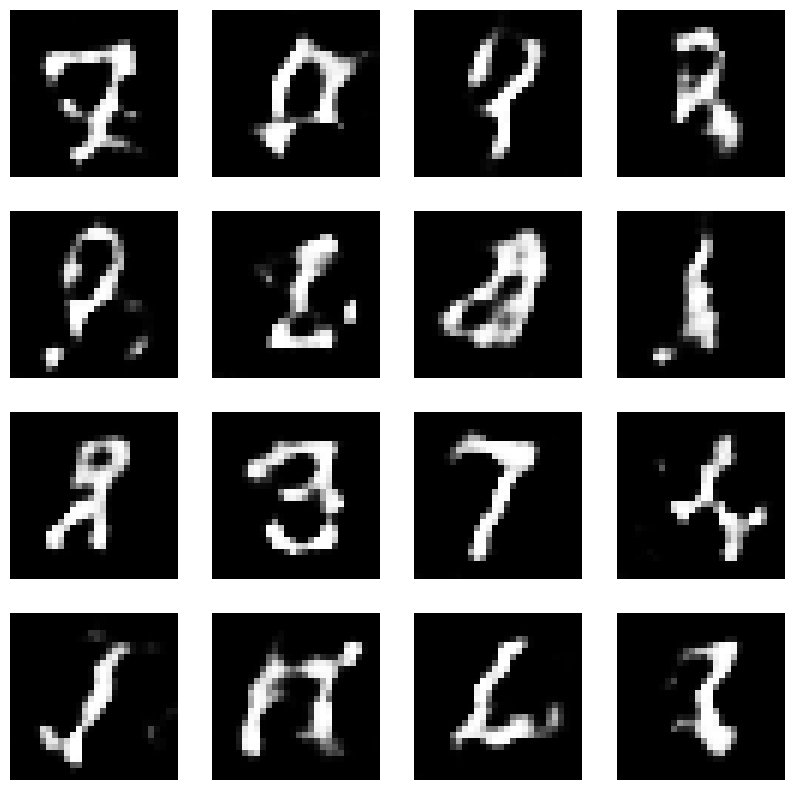

Epoch:  28


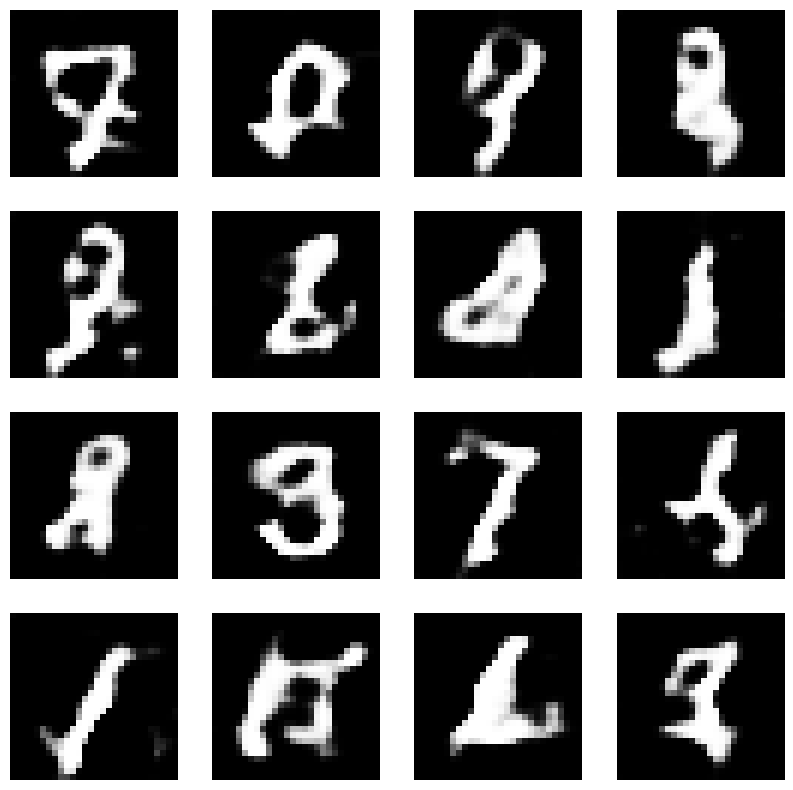

Epoch:  29


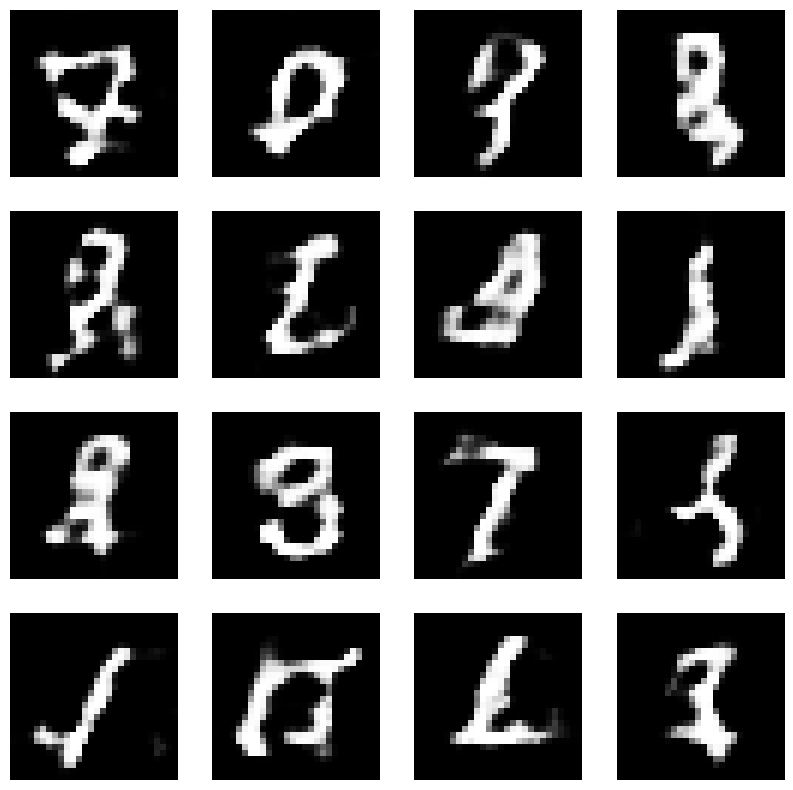

Epoch:  30


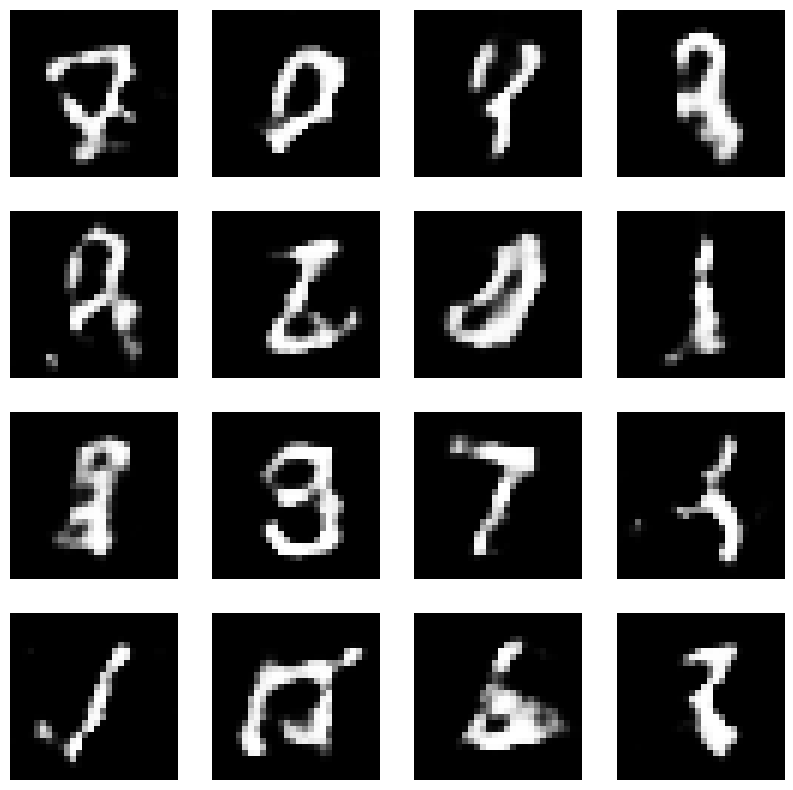

Epoch:  31


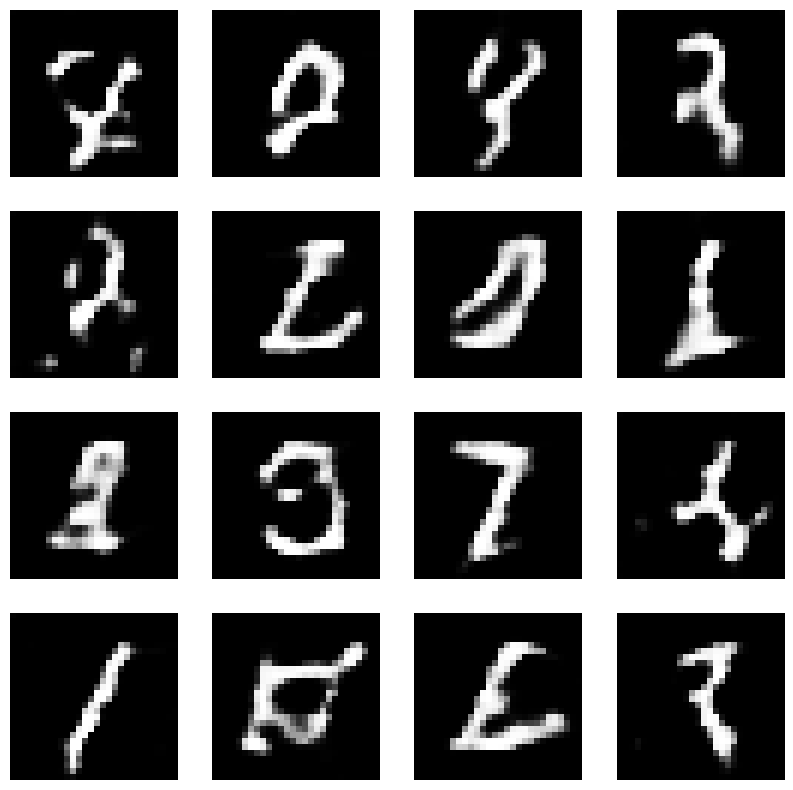

Epoch:  32


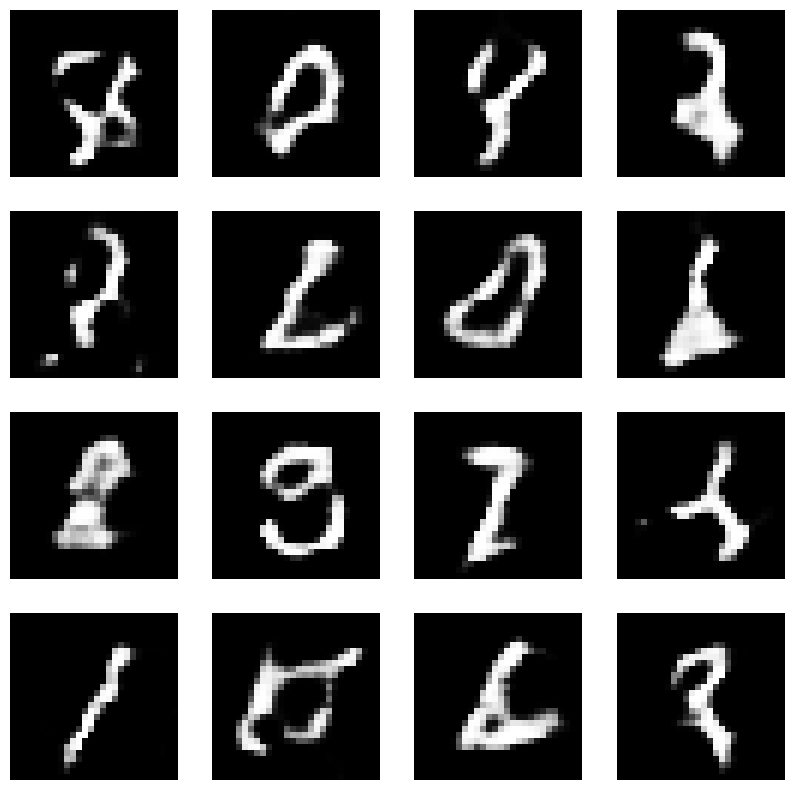

Epoch:  33


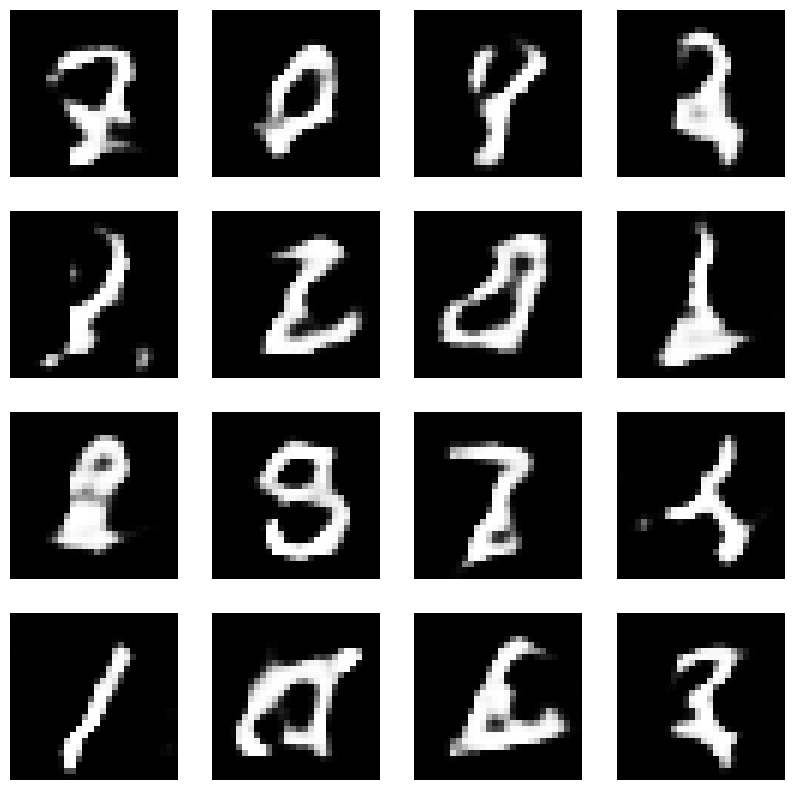

Epoch:  34


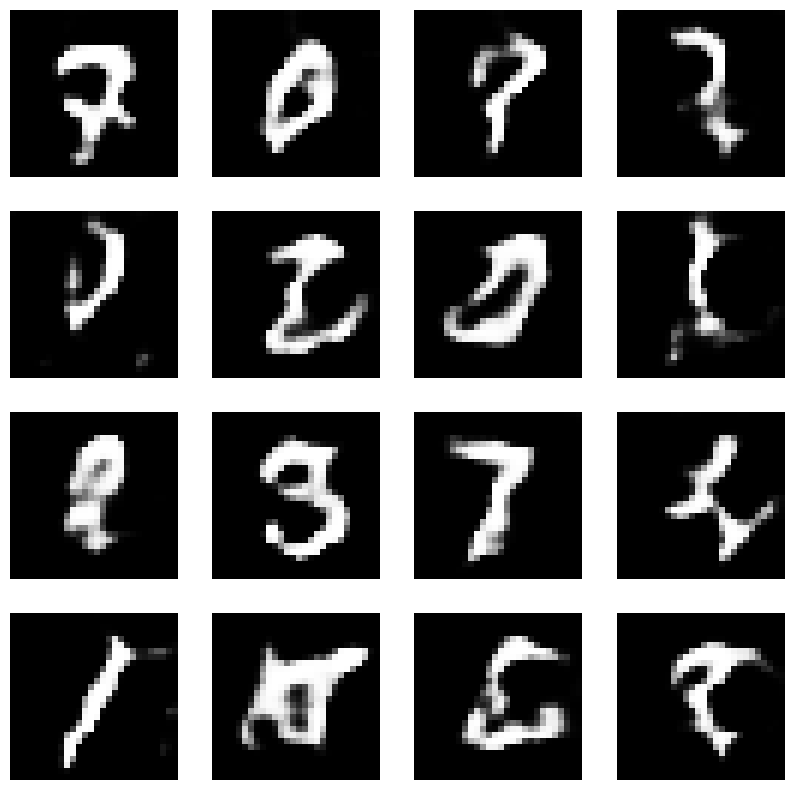

Epoch:  35


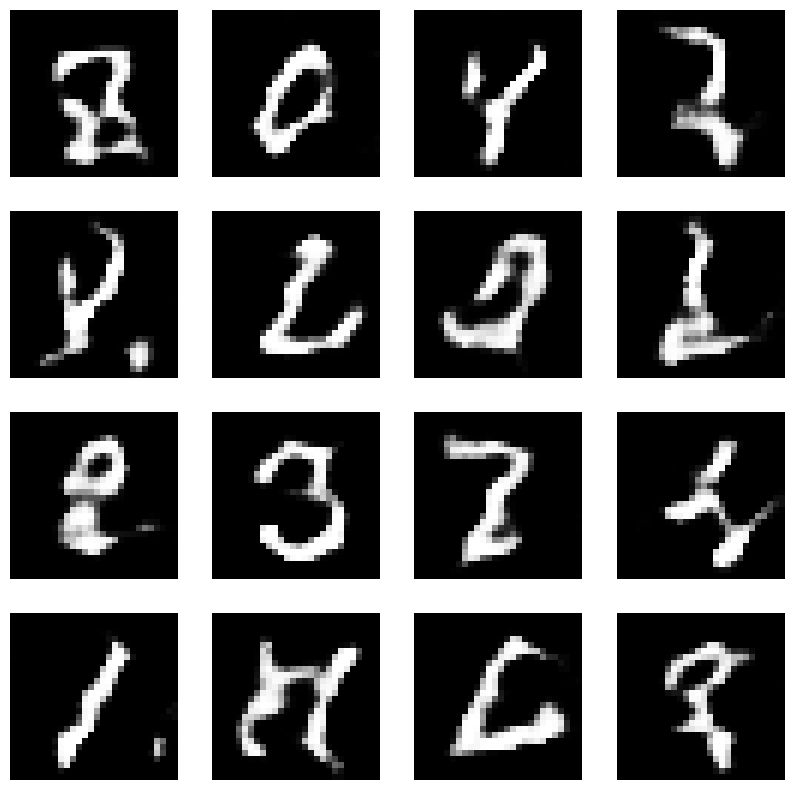

Epoch:  36


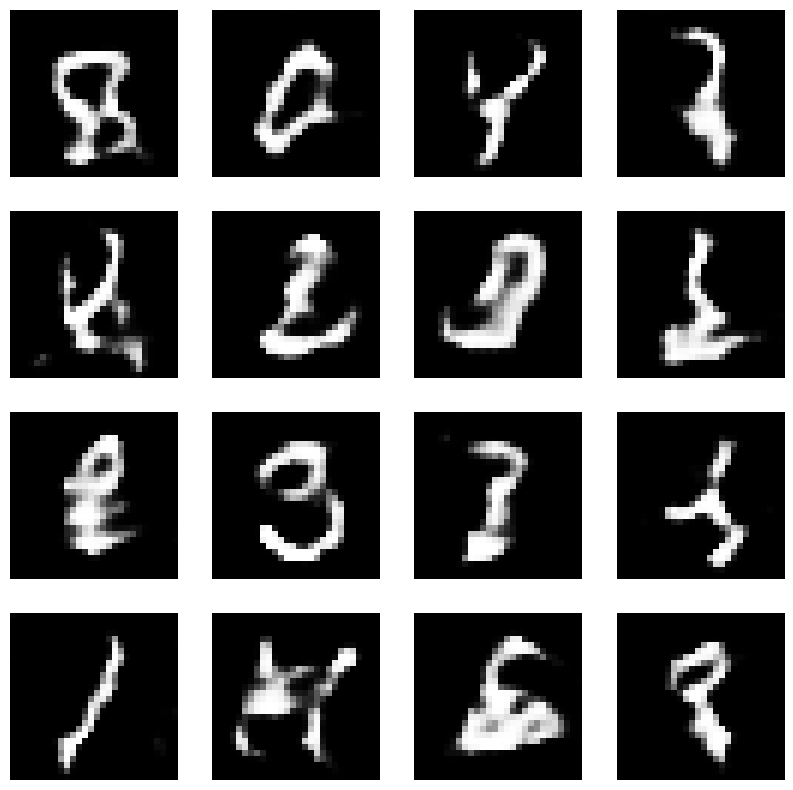

Epoch:  37


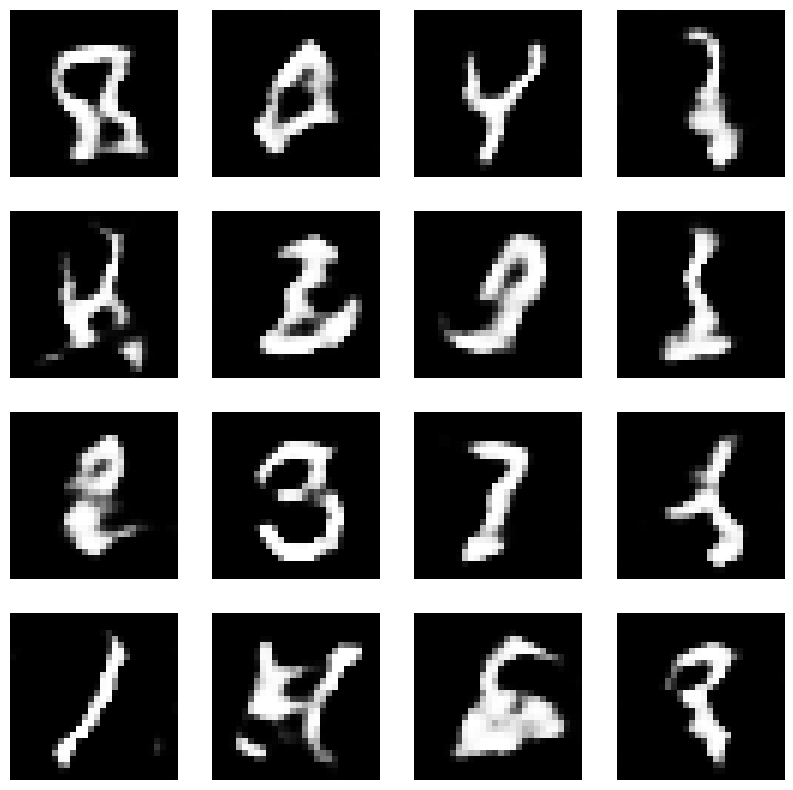

Epoch:  38


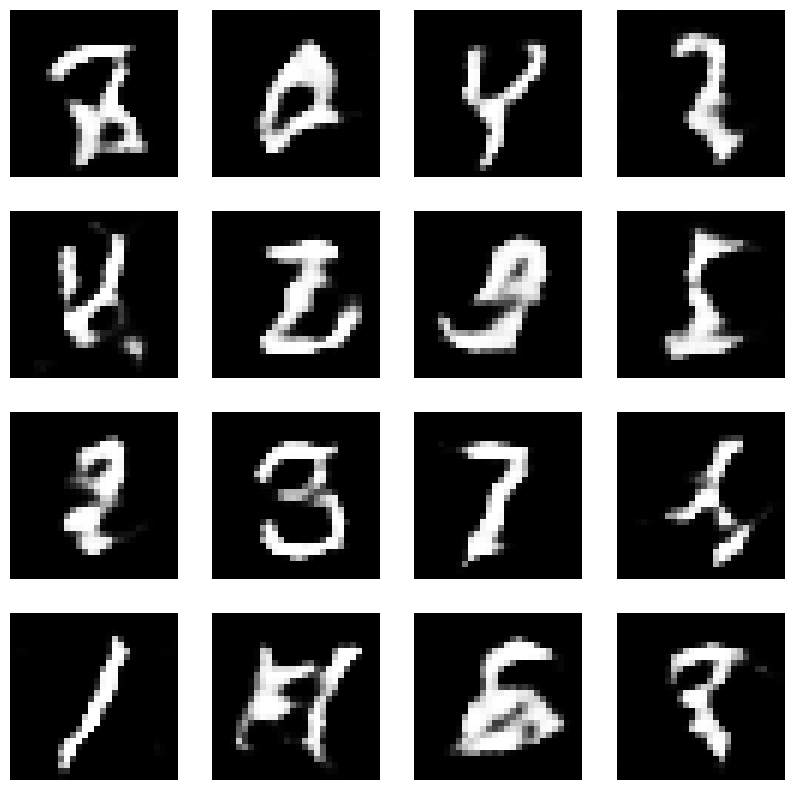

Epoch:  39


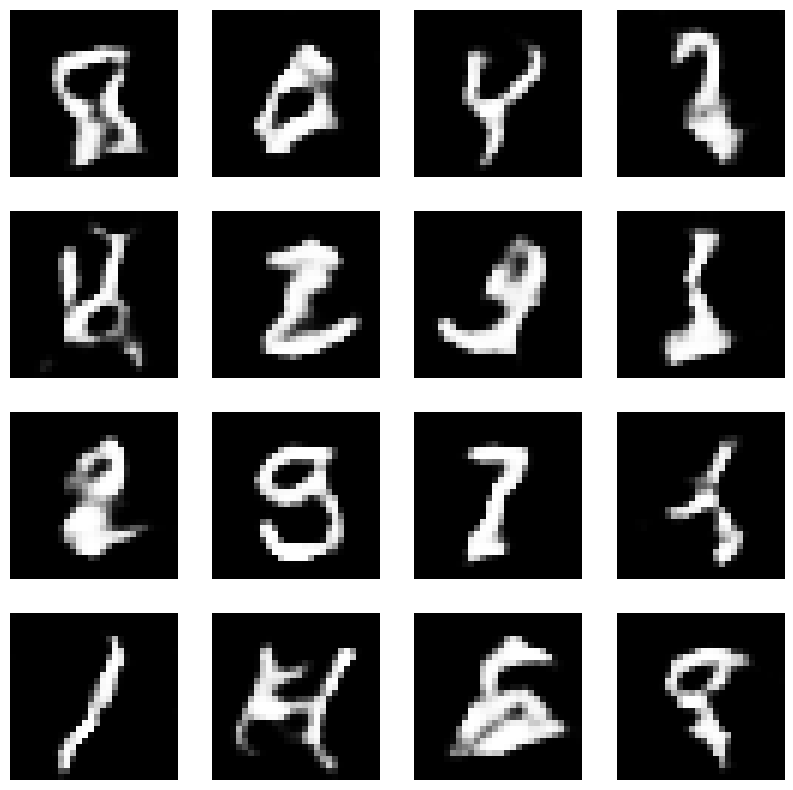

Epoch:  40


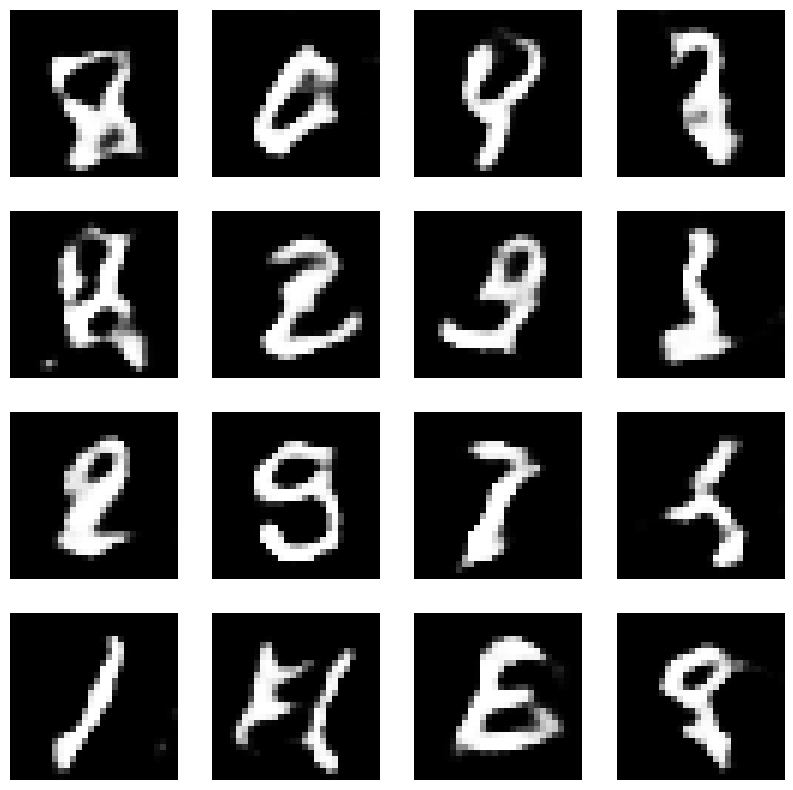

Epoch:  41


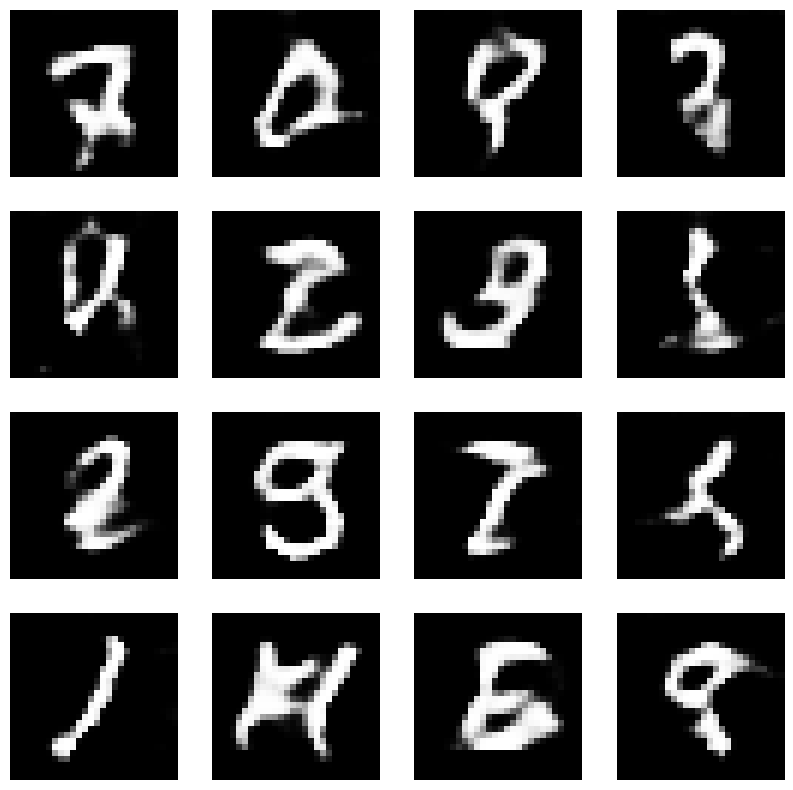

Epoch:  42


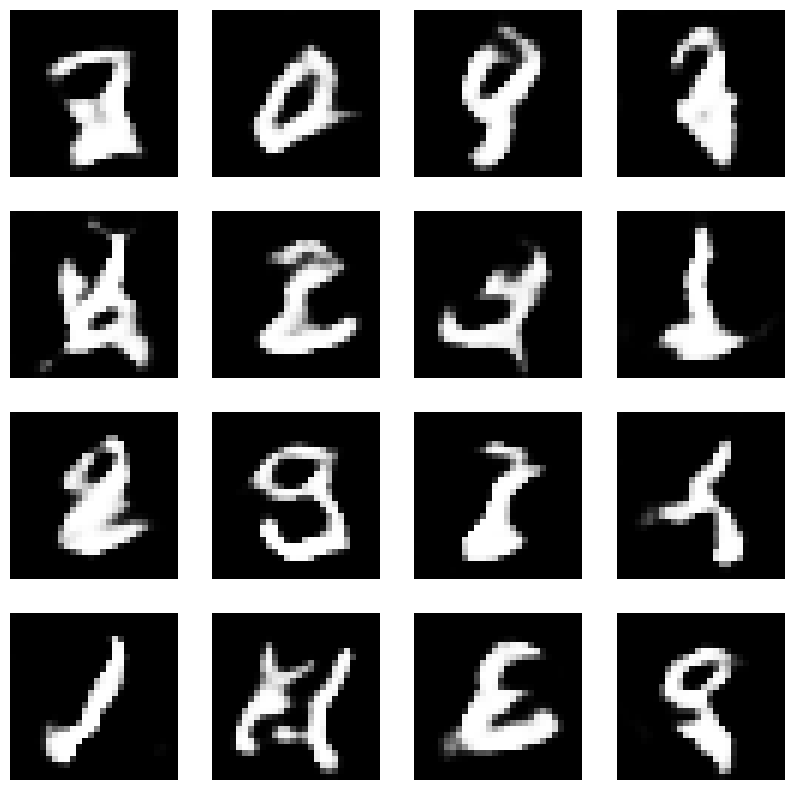

Epoch:  43


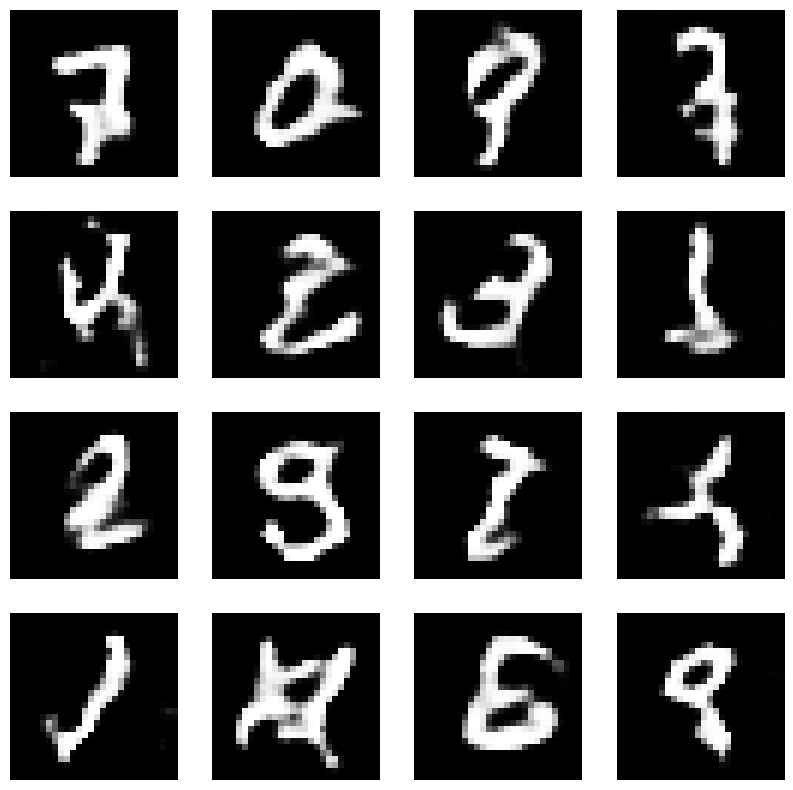

Epoch:  44


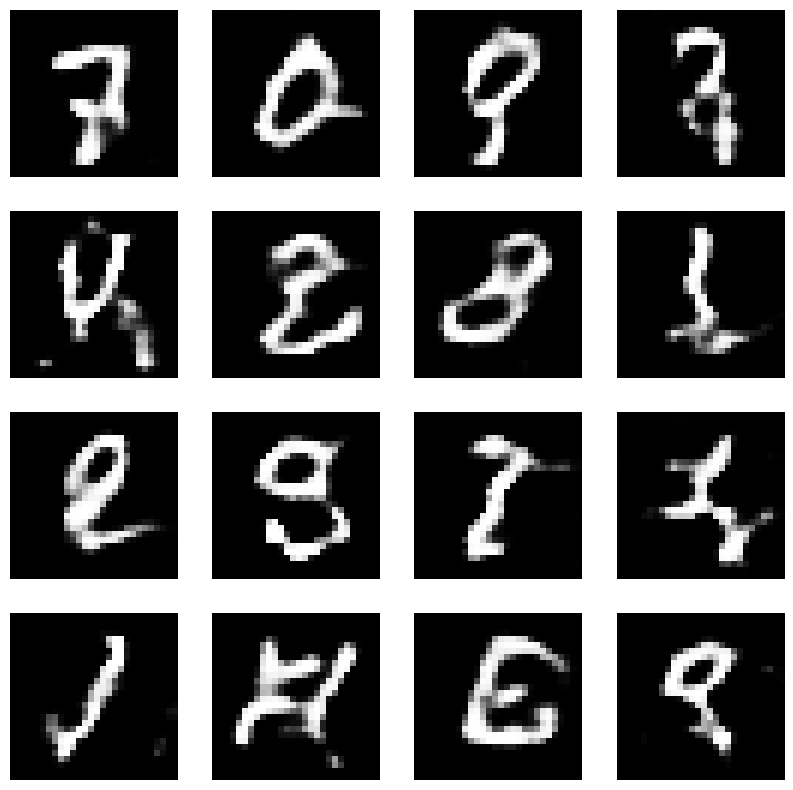

Epoch:  45


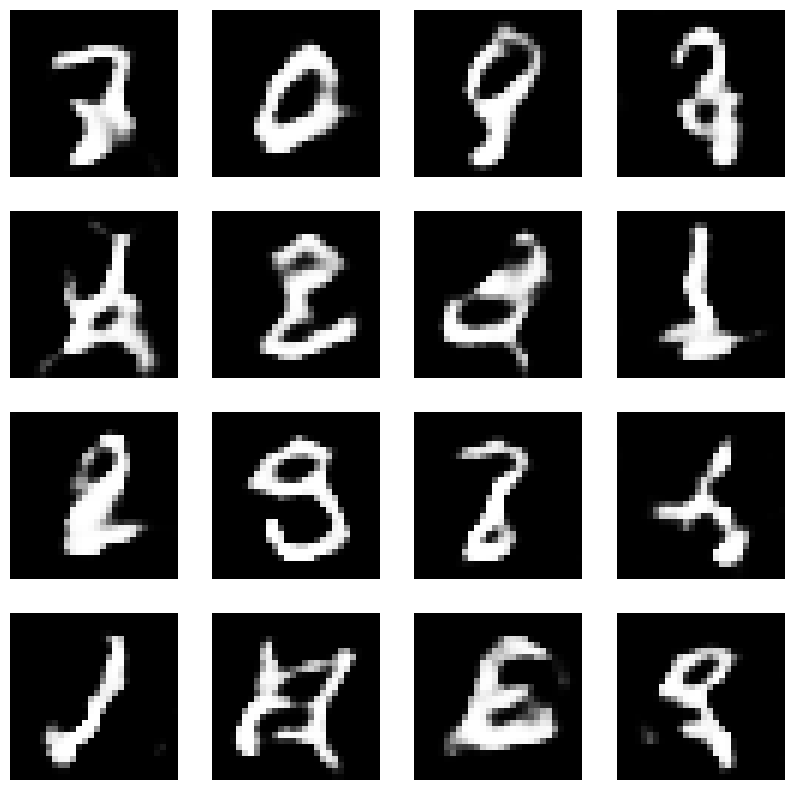

Epoch:  46


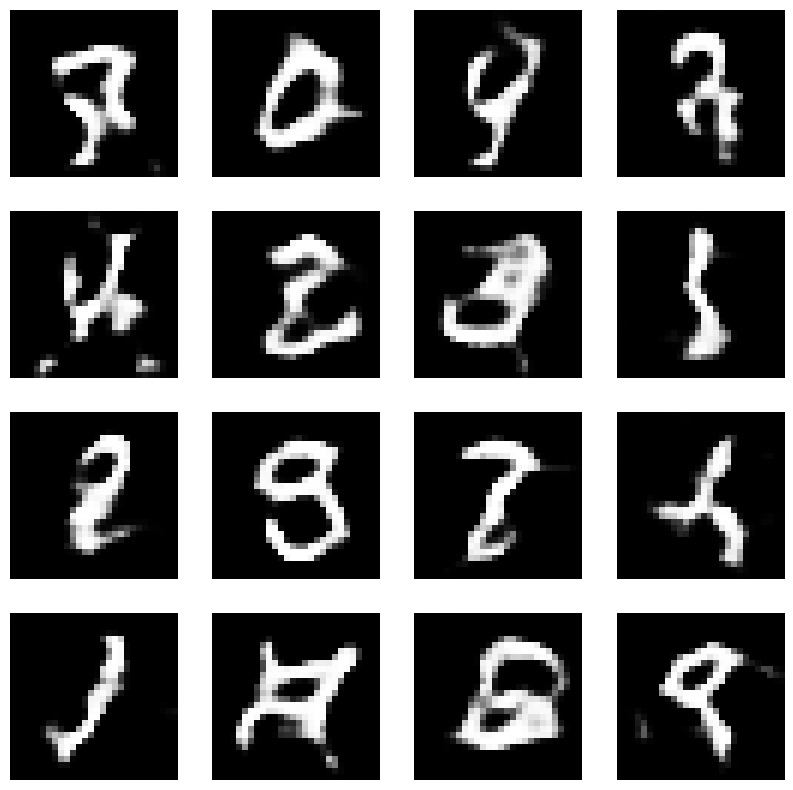

Epoch:  47


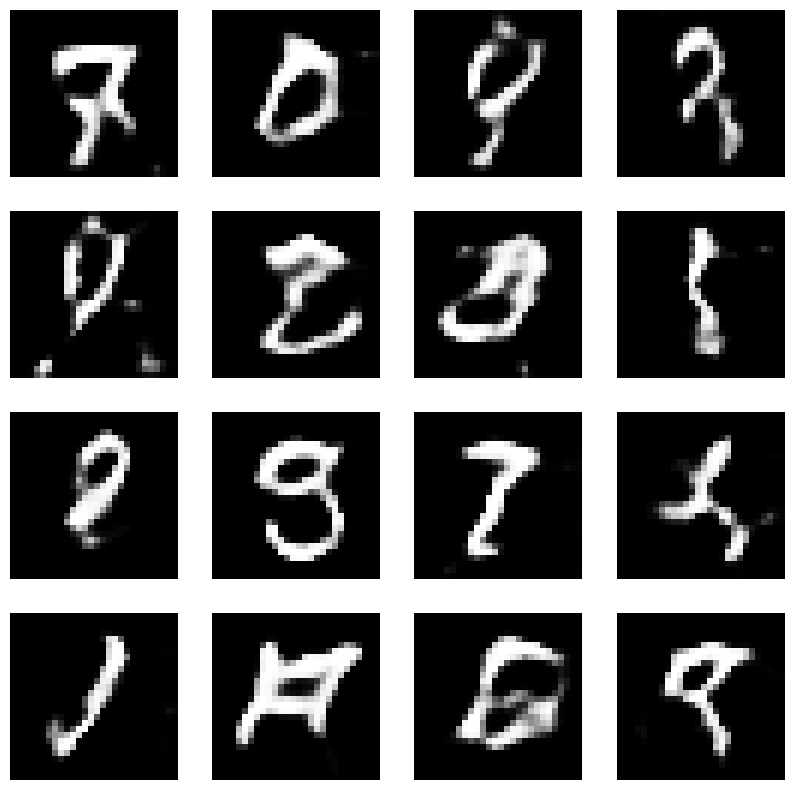

Epoch:  48


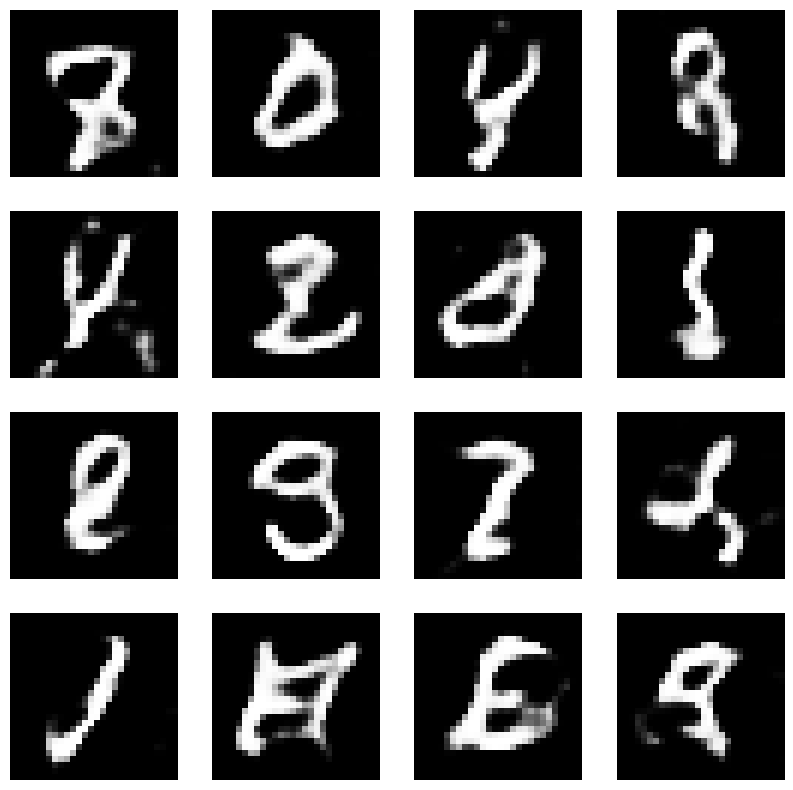

Epoch:  49


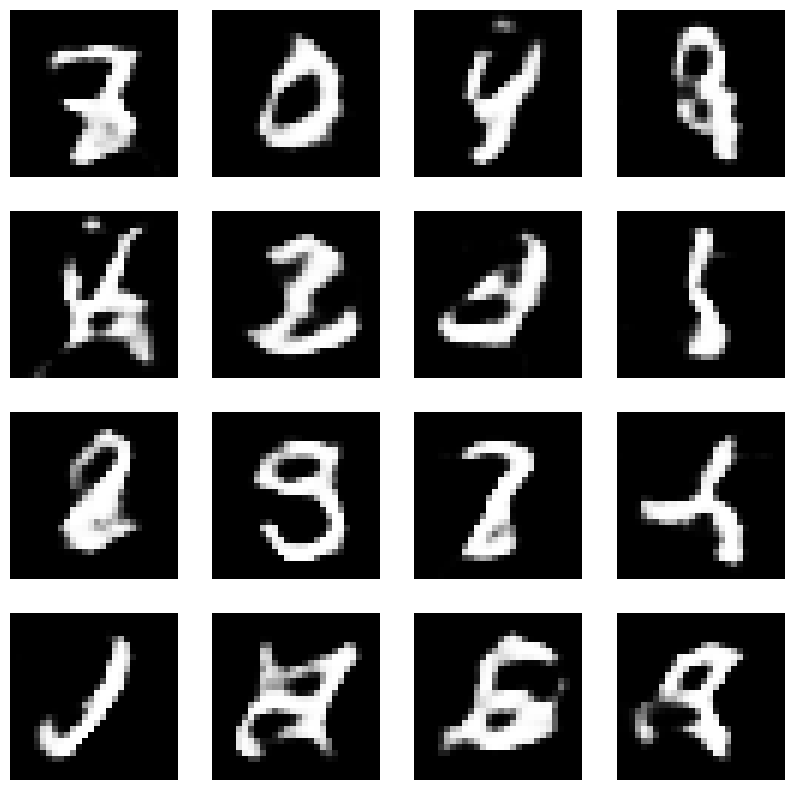

Epoch:  50


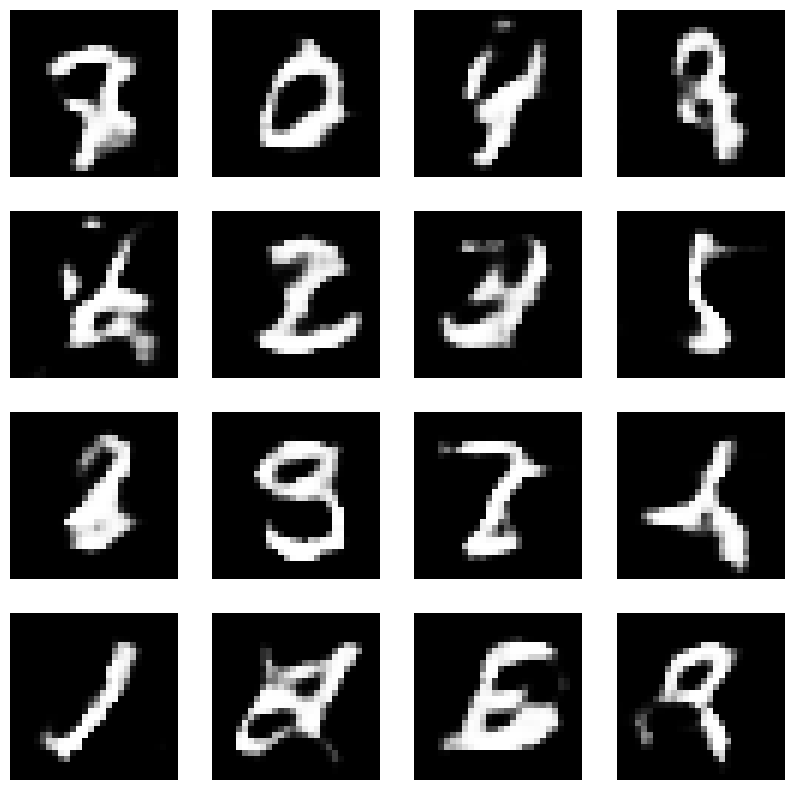

Epoch:  51


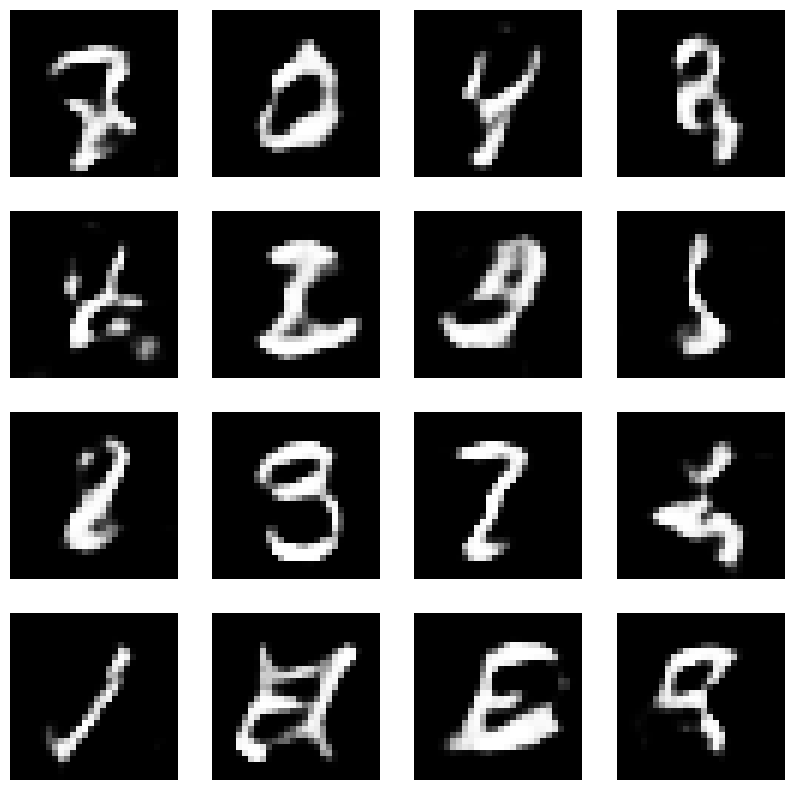

Epoch:  52


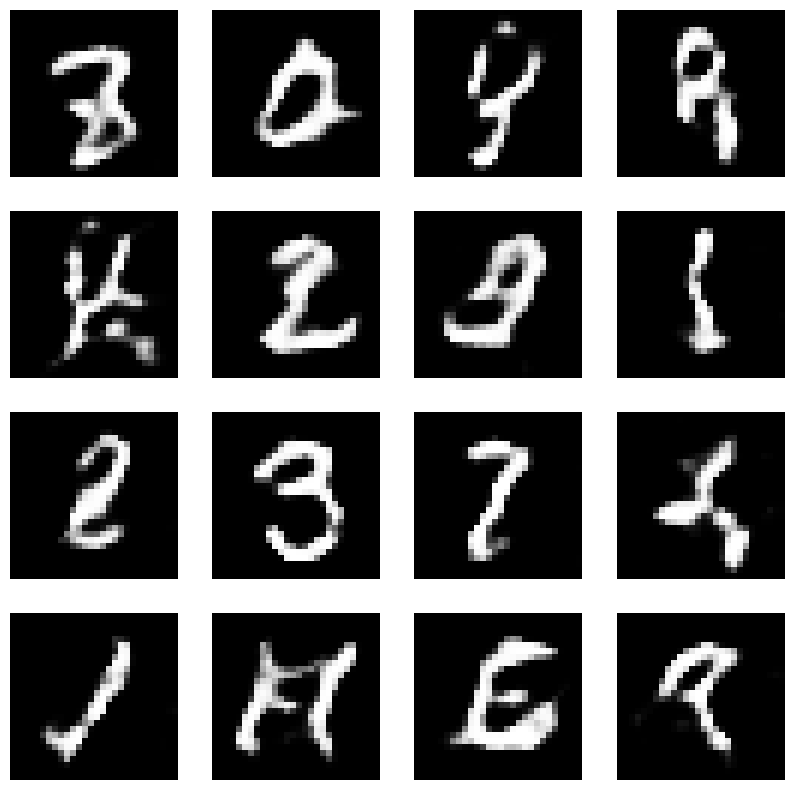

Epoch:  53


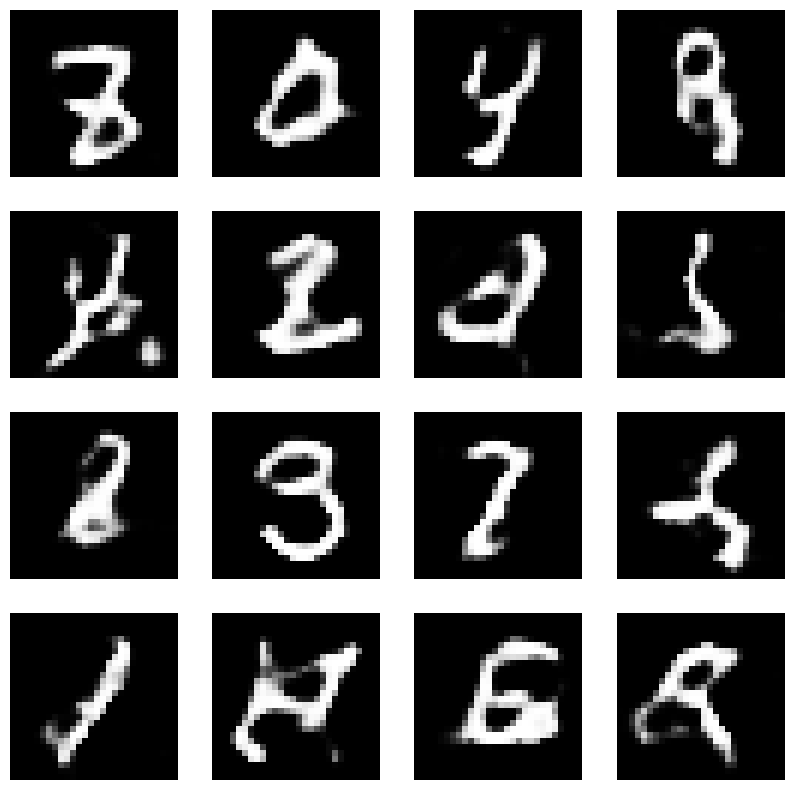

Epoch:  54


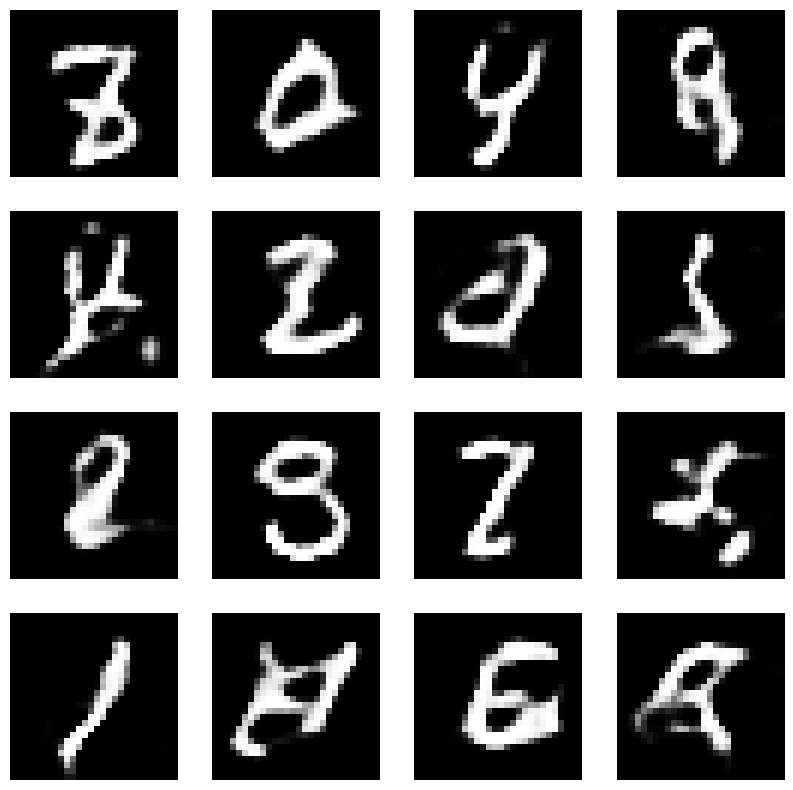

Epoch:  55


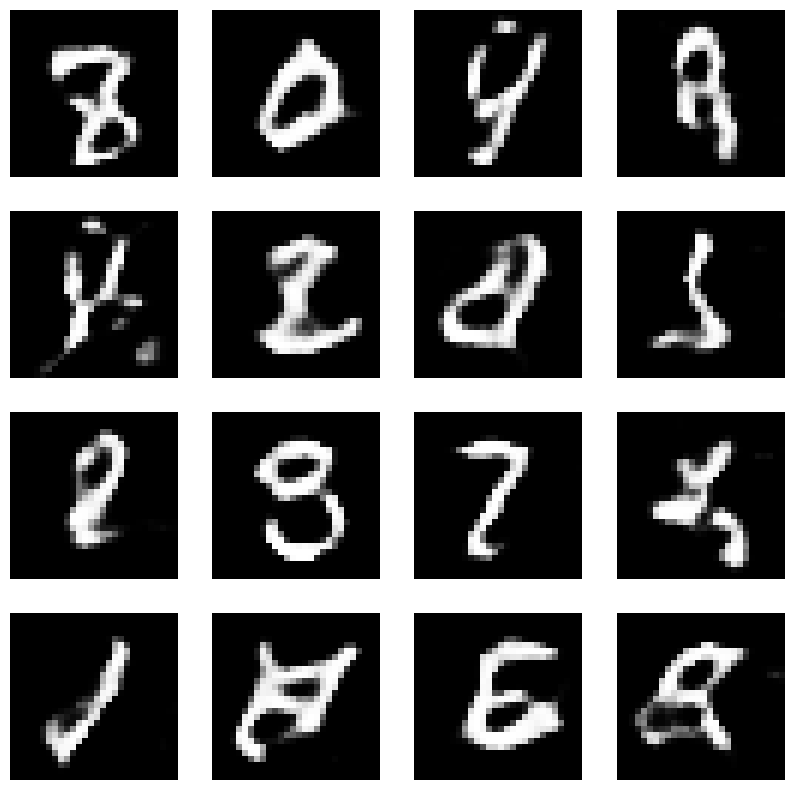

Epoch:  56


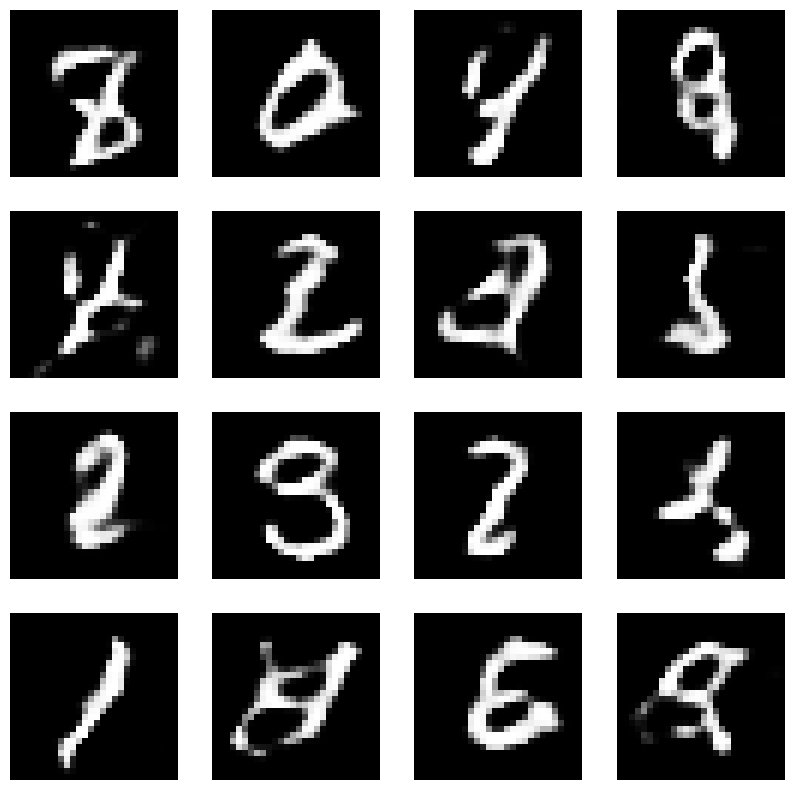

Epoch:  57


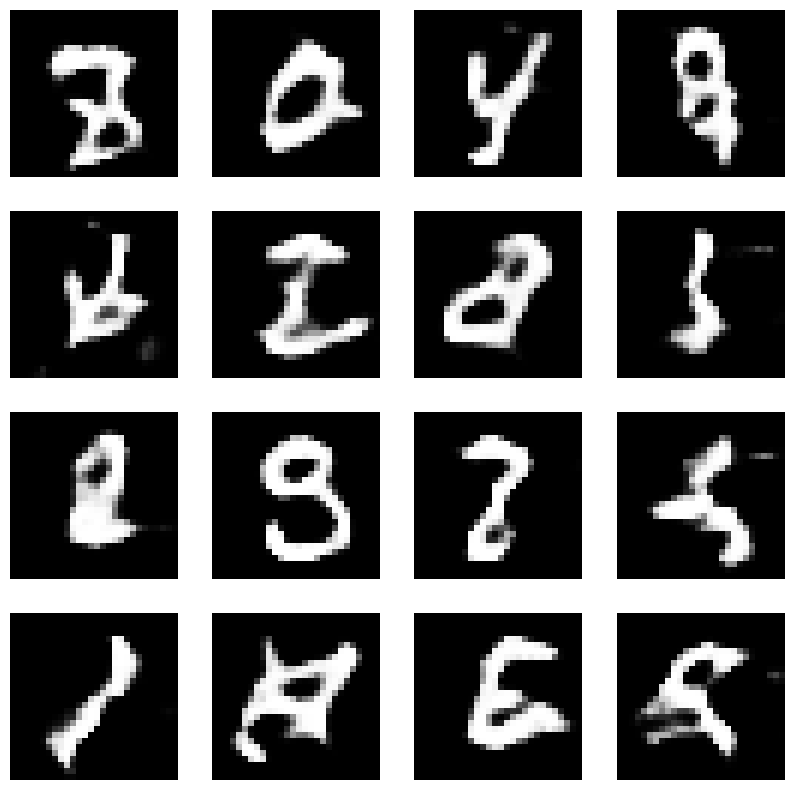

Epoch:  58


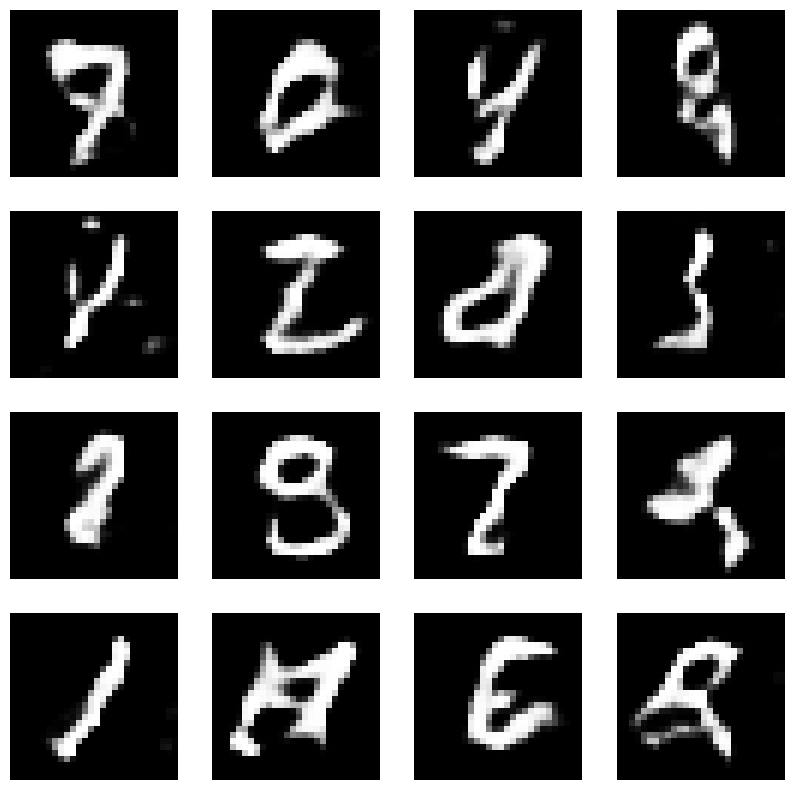

Epoch:  59


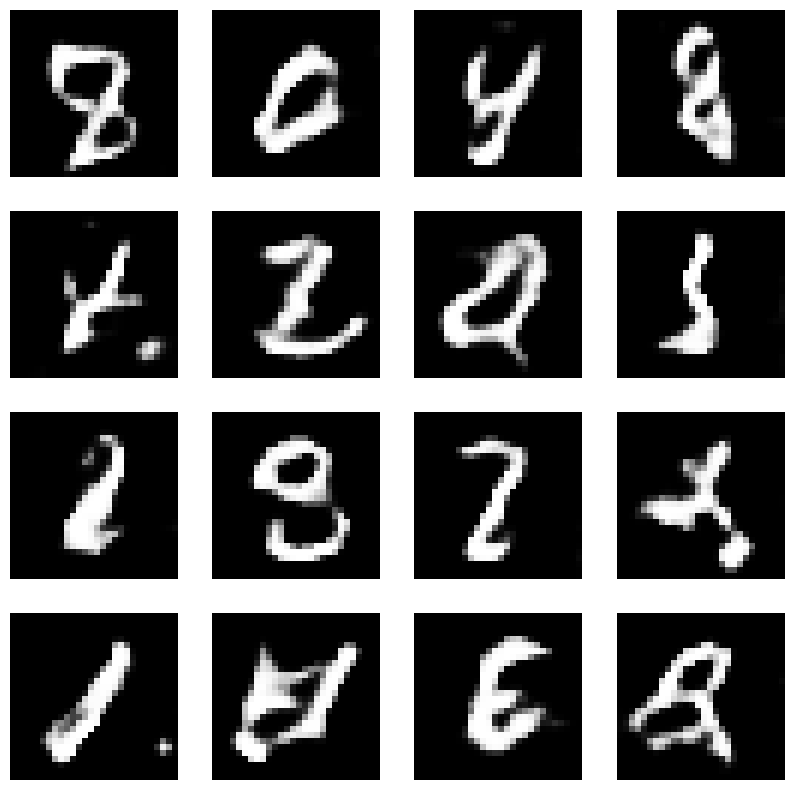

Epoch:  60


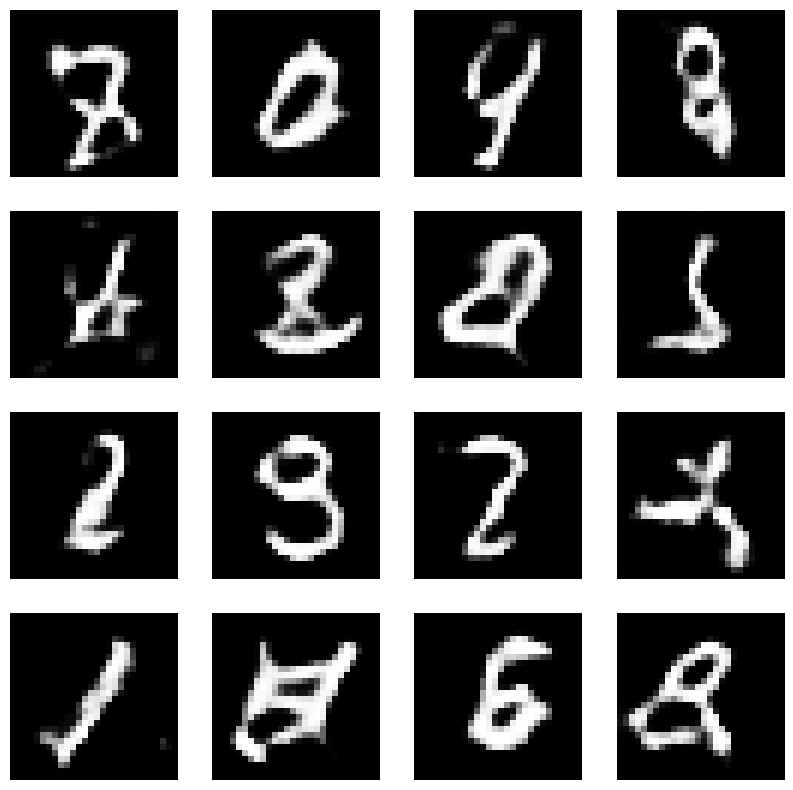

Epoch:  61


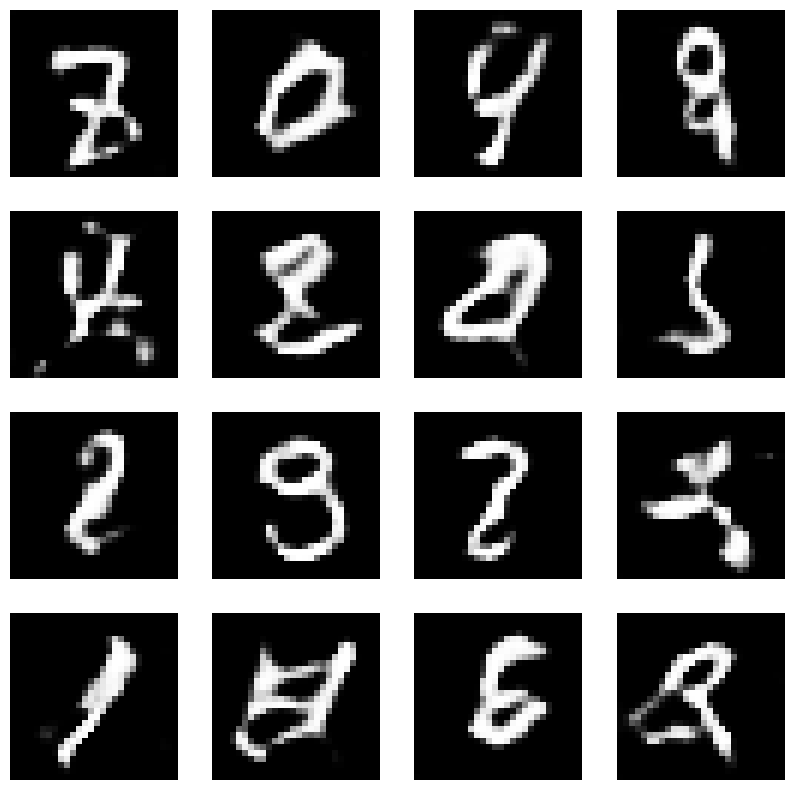

Epoch:  62


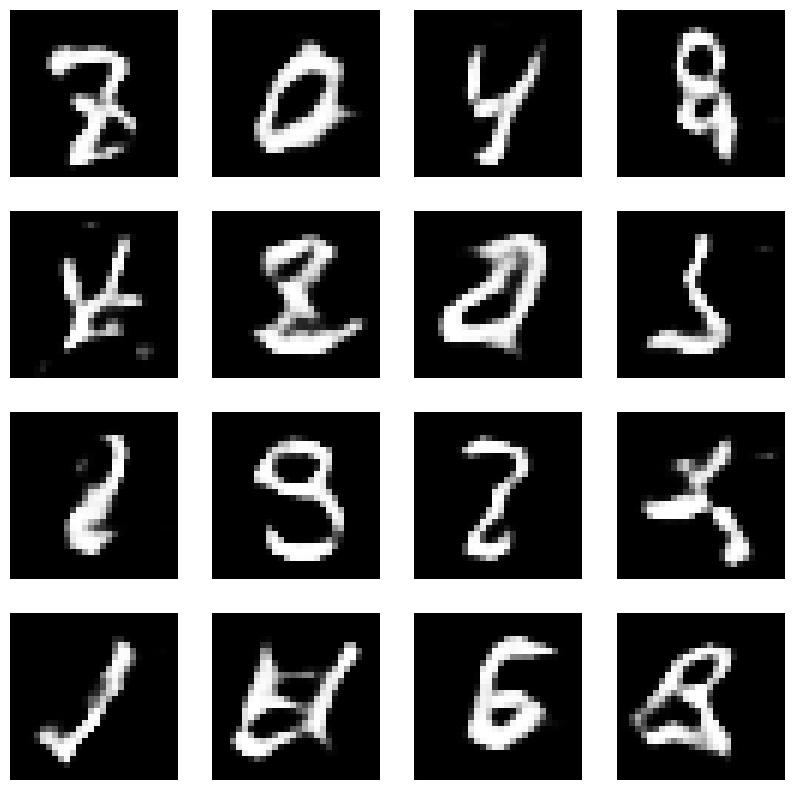

Epoch:  63


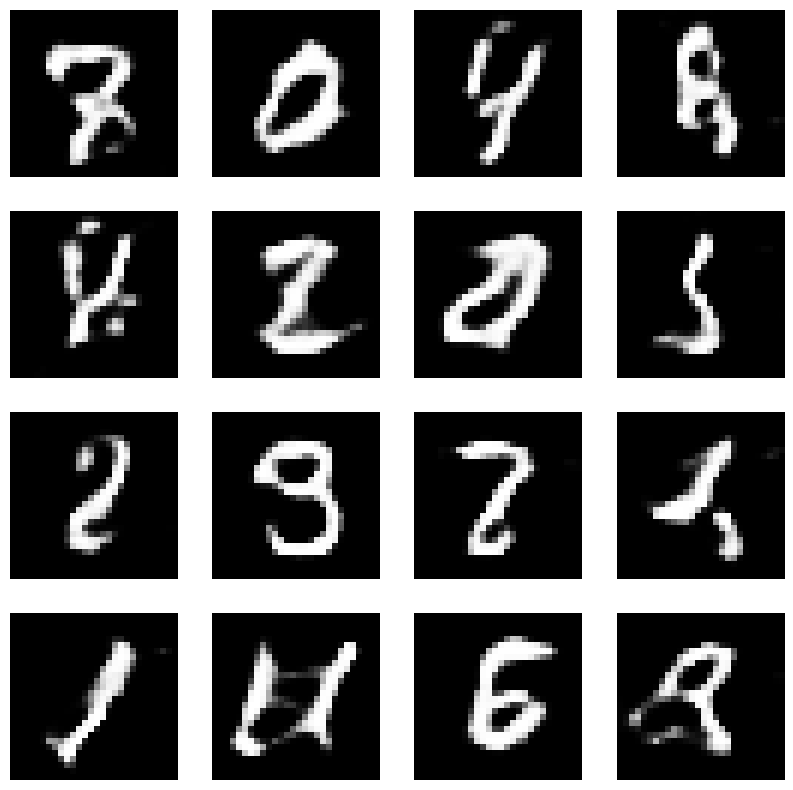

Epoch:  64


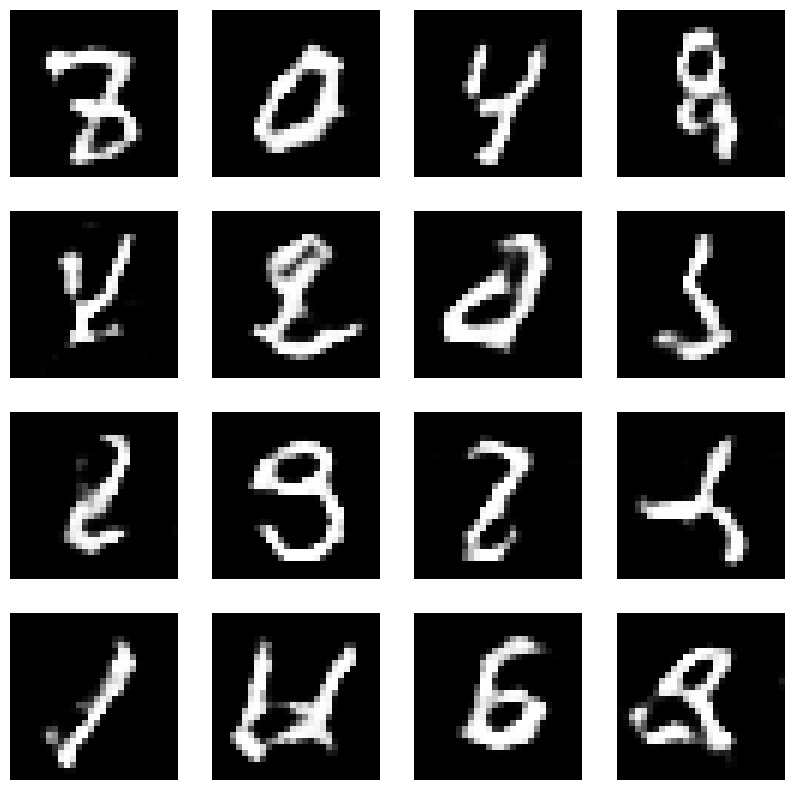

Epoch:  65


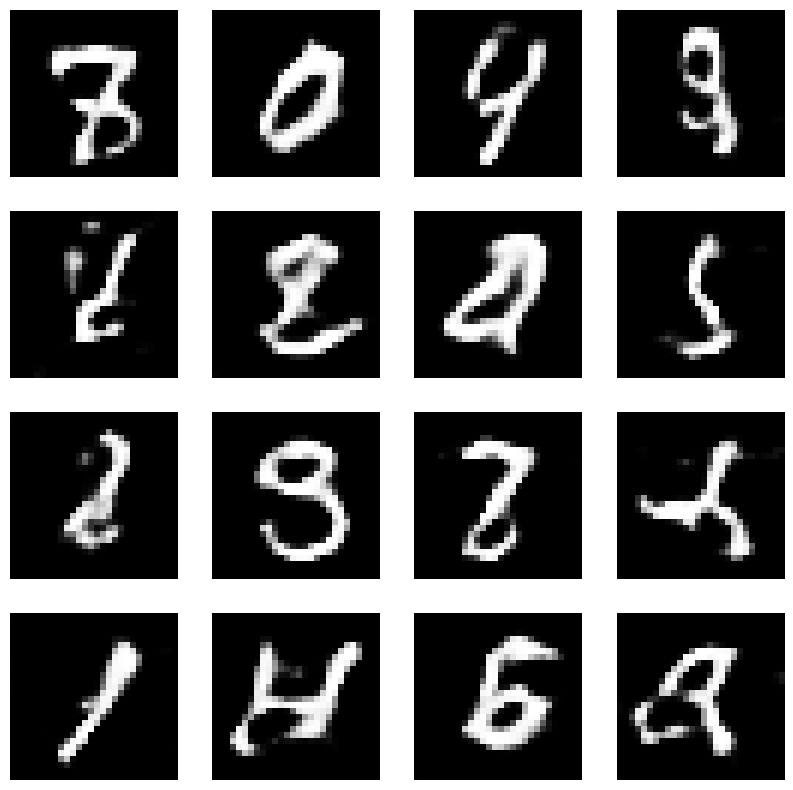

Epoch:  66


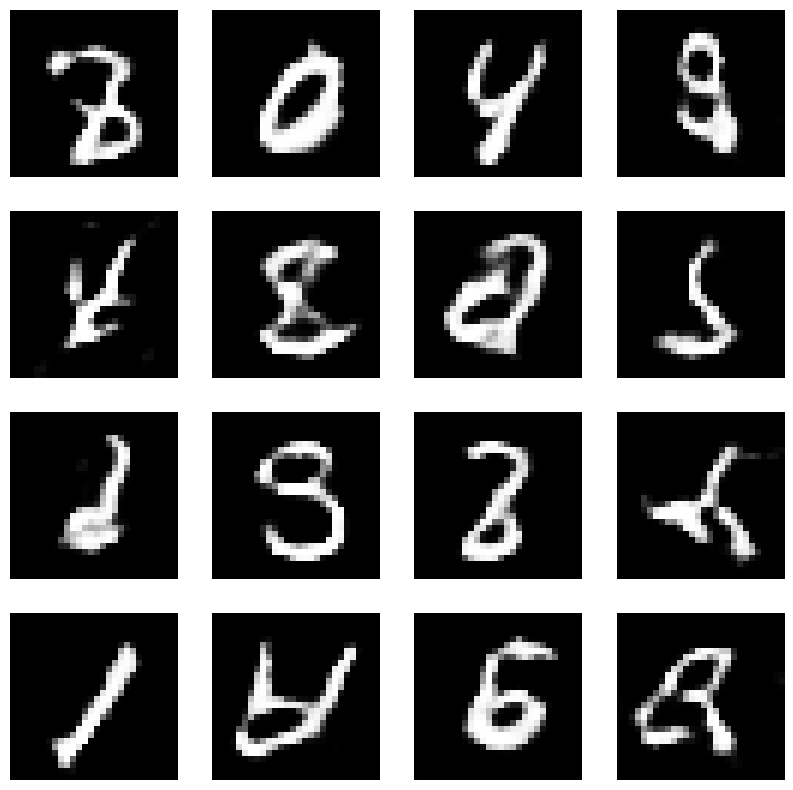

Epoch:  67


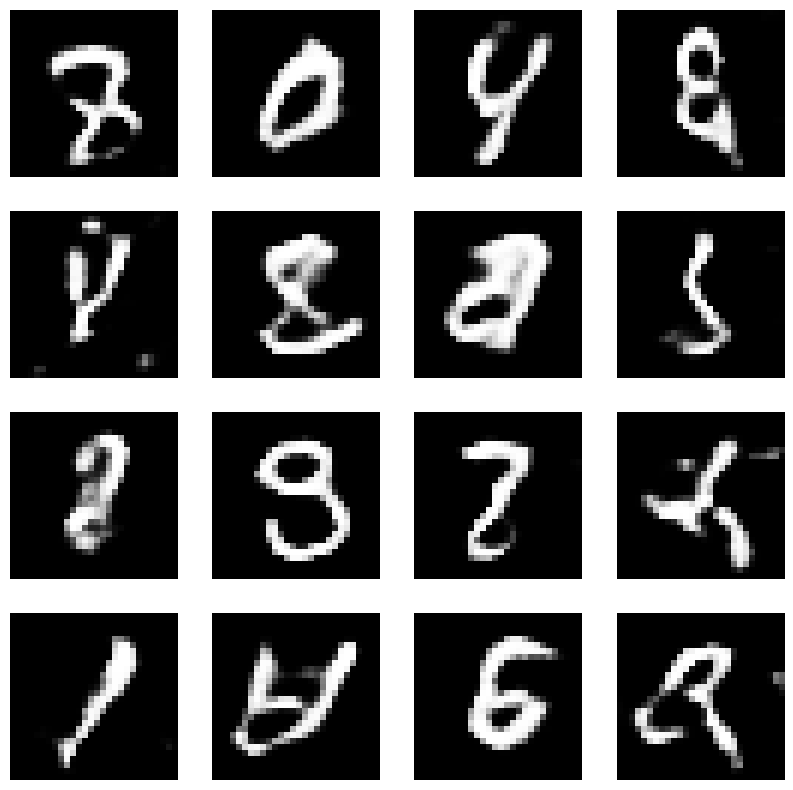

Epoch:  68


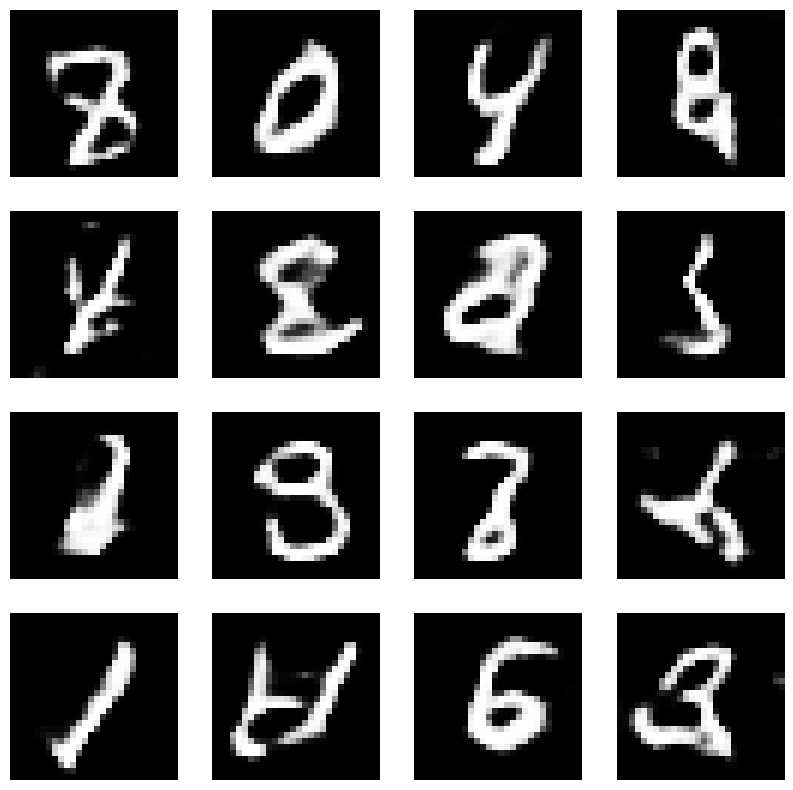

Epoch:  69


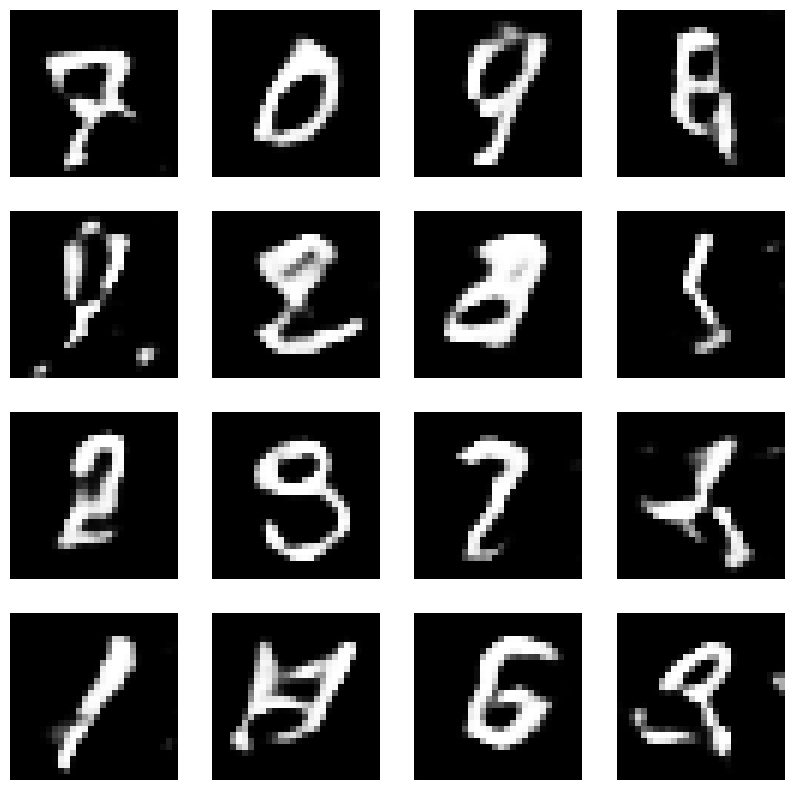

Epoch:  70


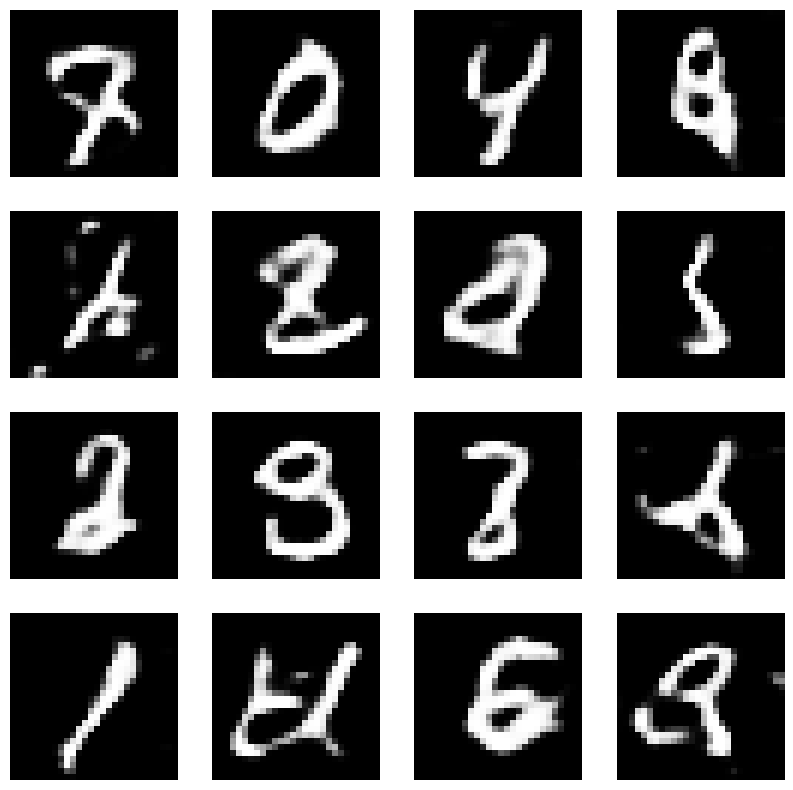

Epoch:  71


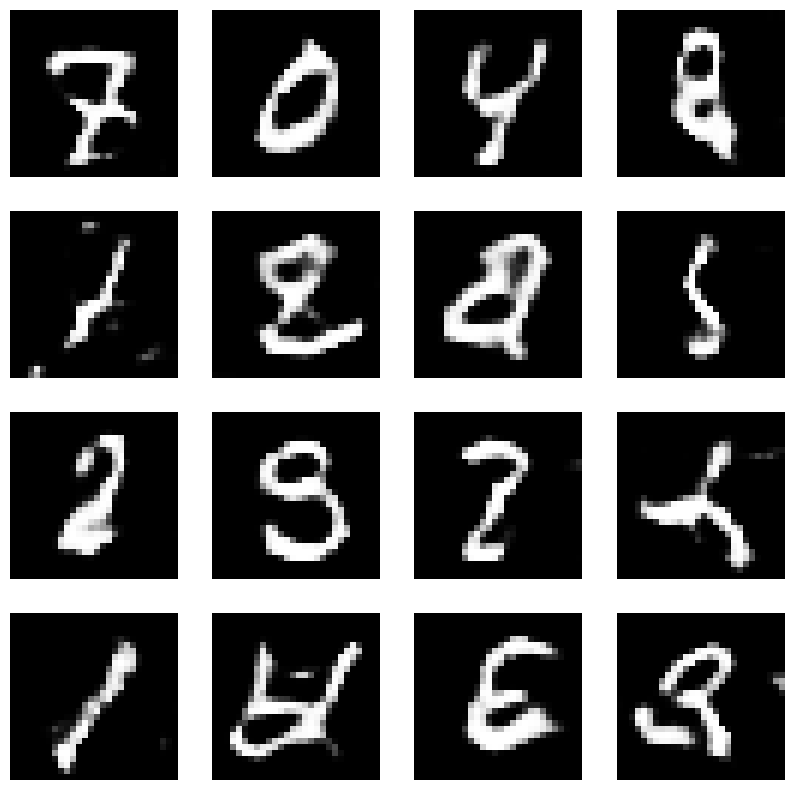

Epoch:  72


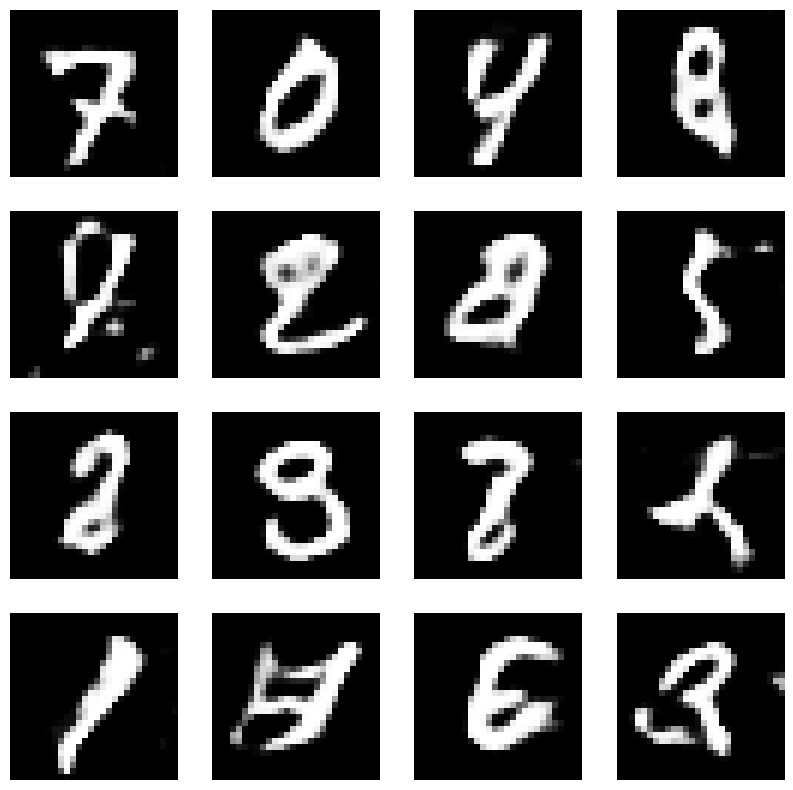

Epoch:  73


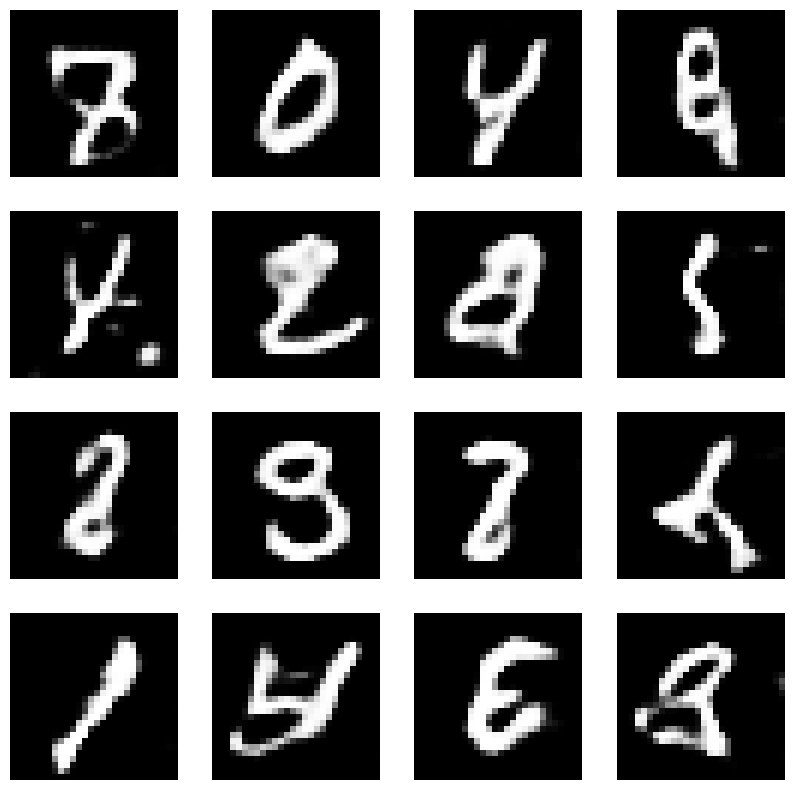

Epoch:  74


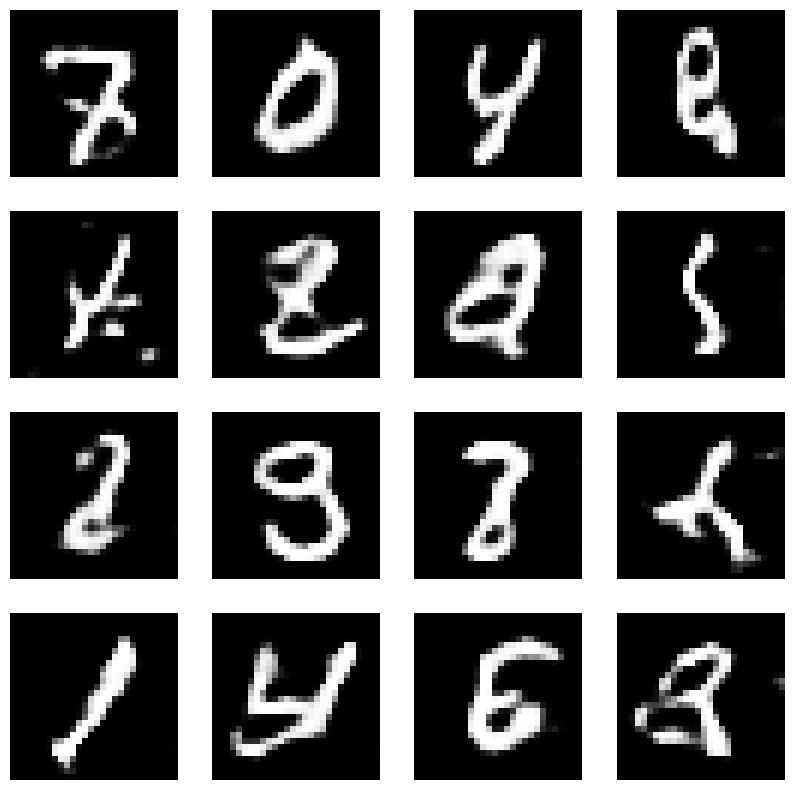

Epoch:  75


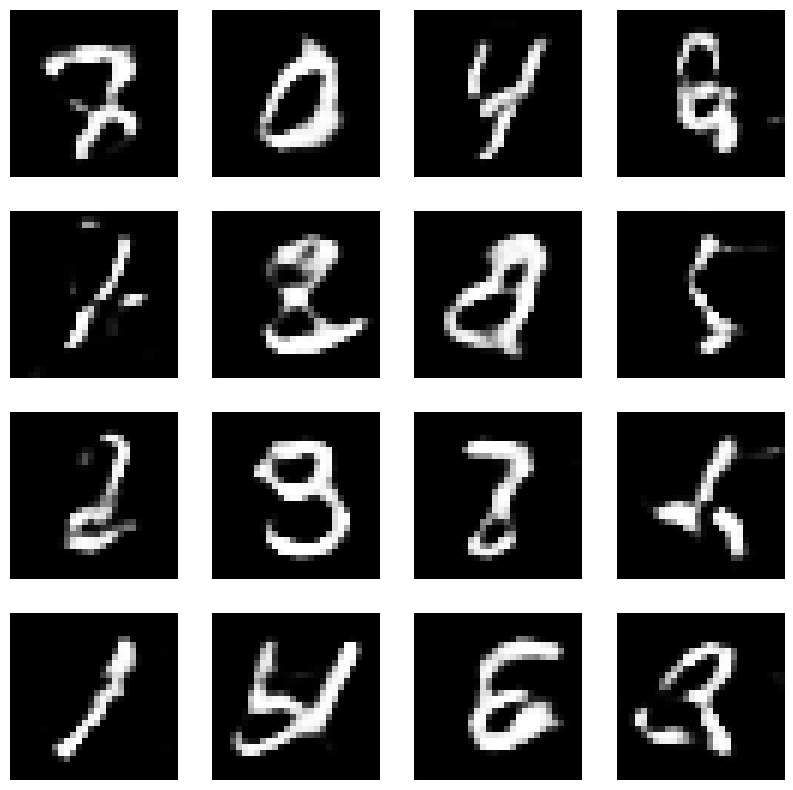

Epoch:  76


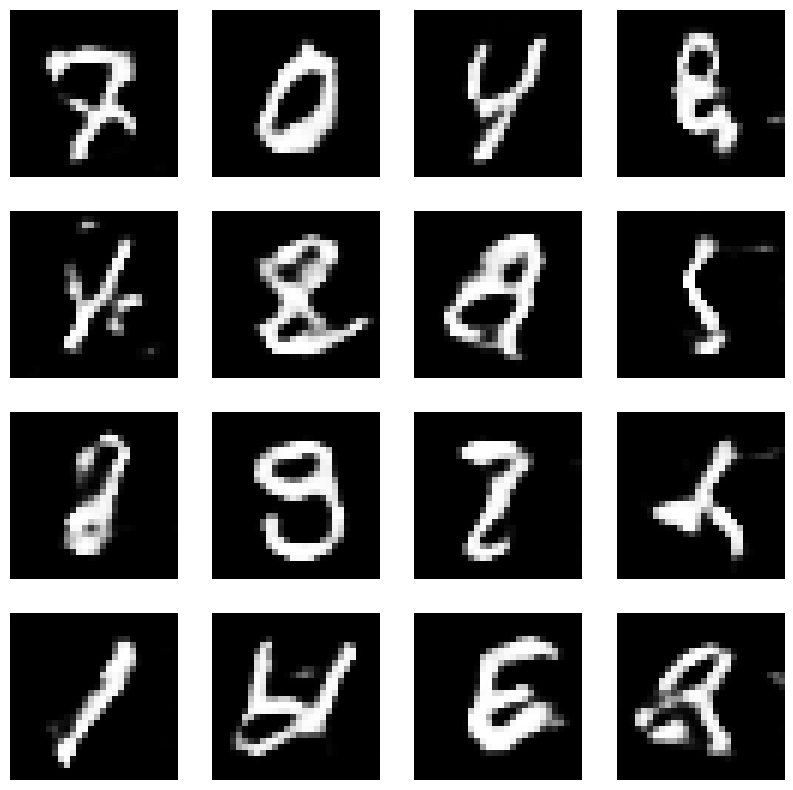

Epoch:  77


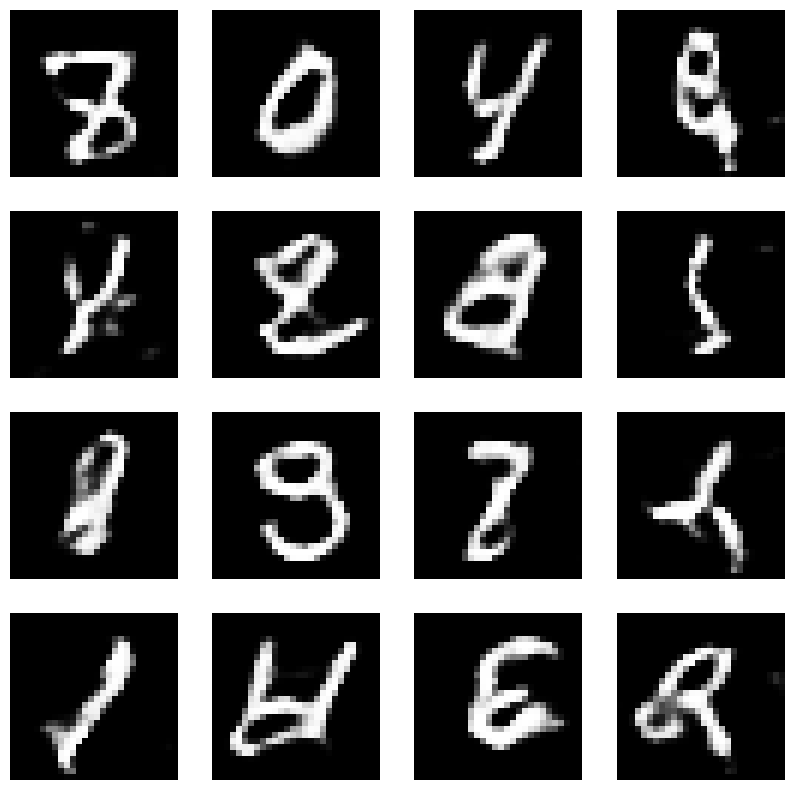

Epoch:  78


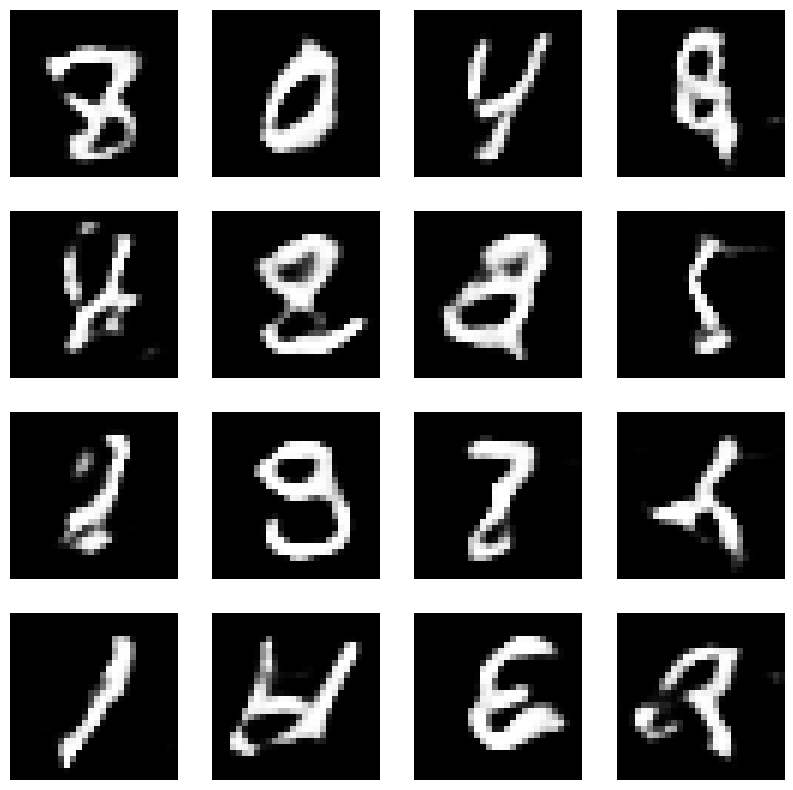

Epoch:  79


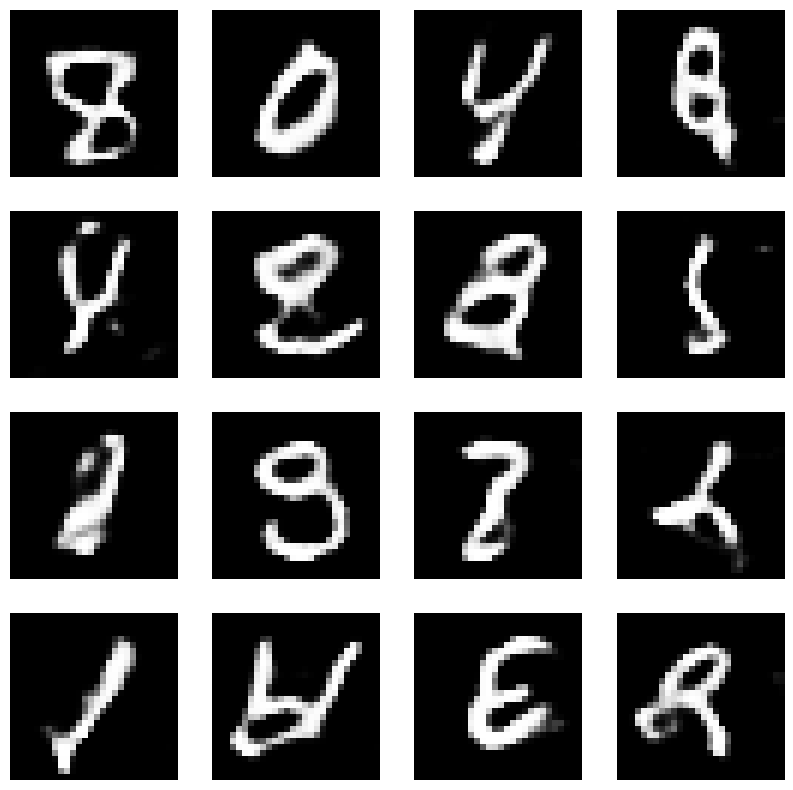

Epoch:  80


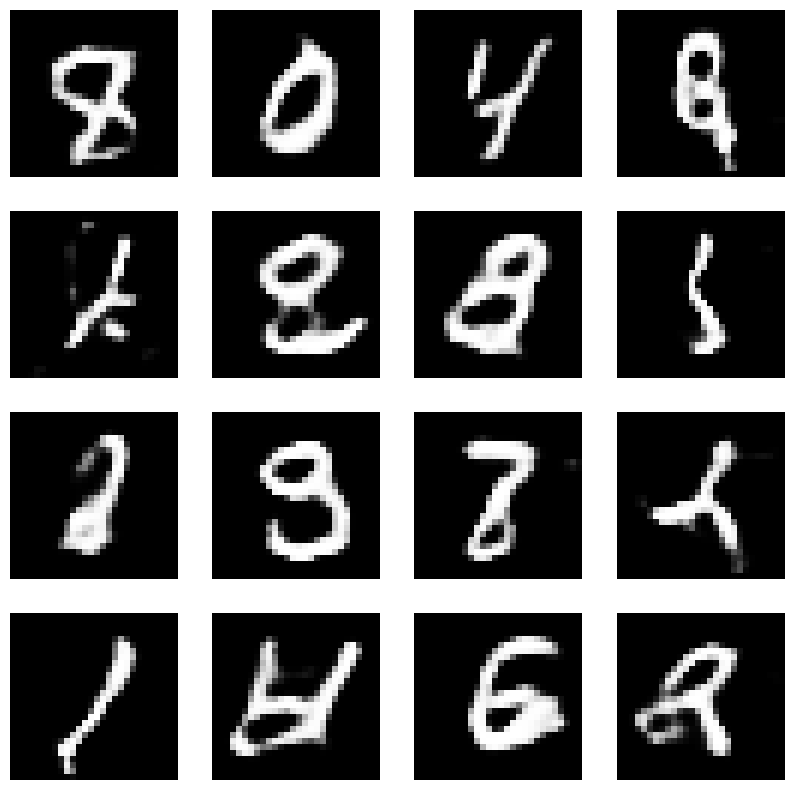

Epoch:  81


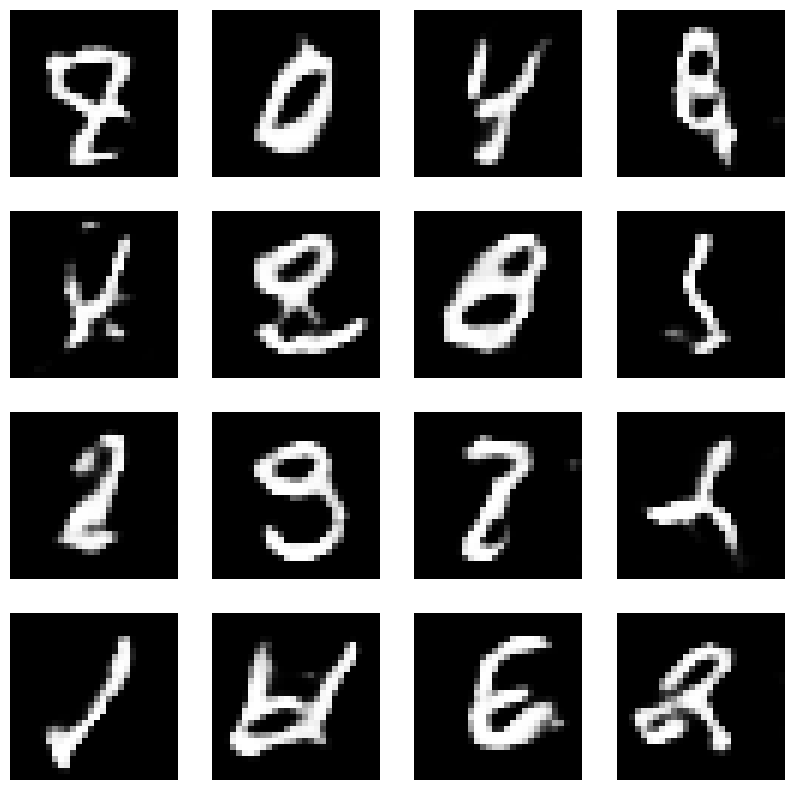

Epoch:  82


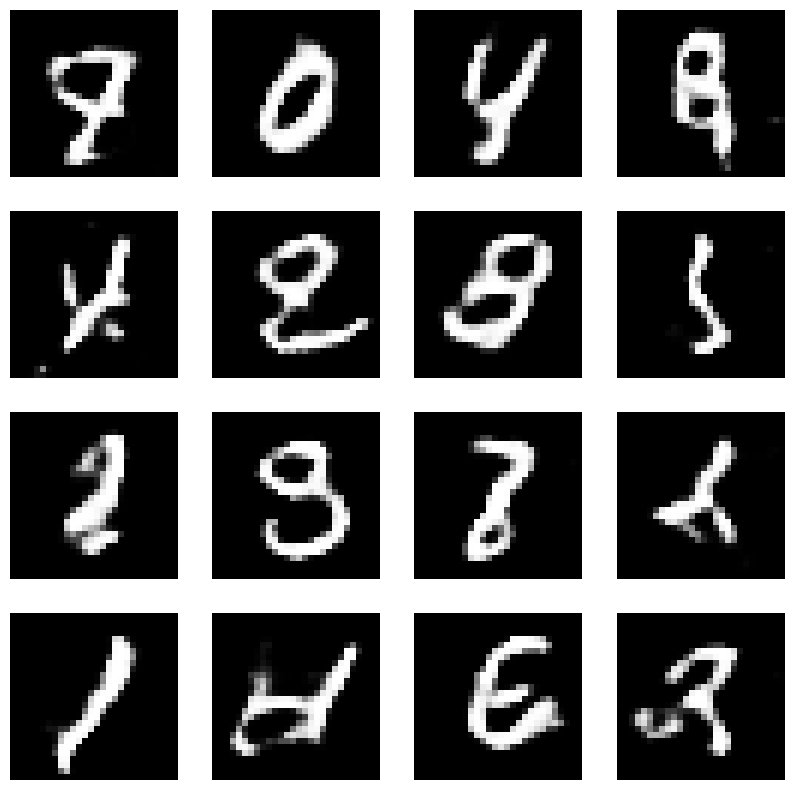

Epoch:  83


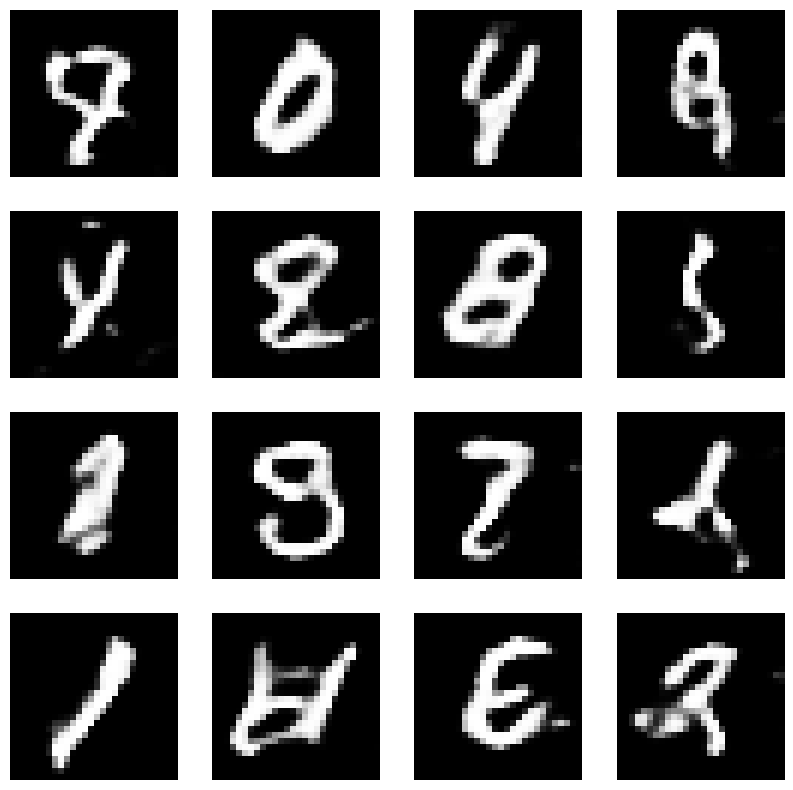

Epoch:  84


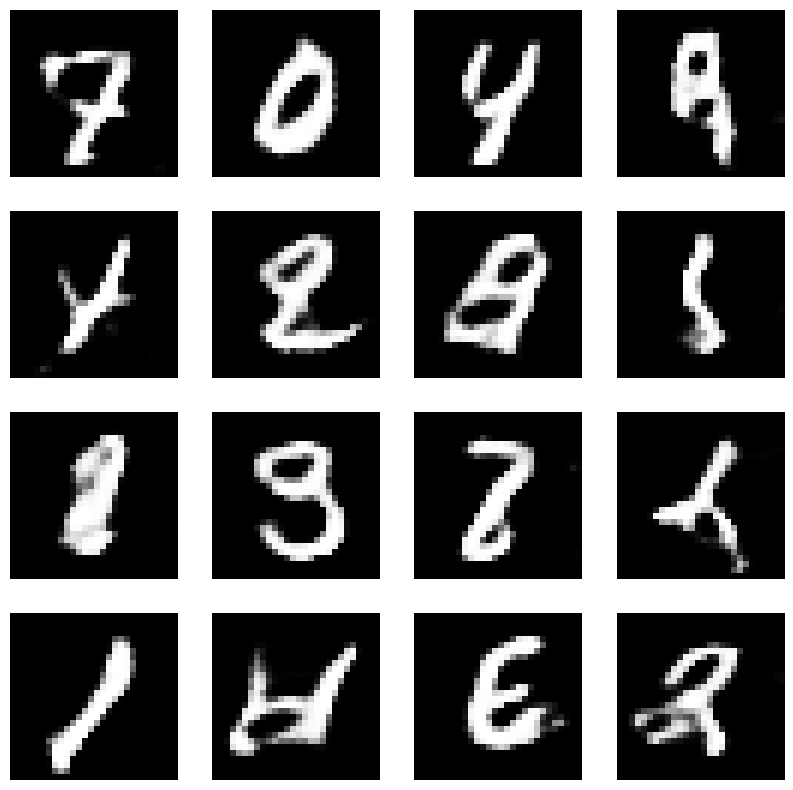

Epoch:  85


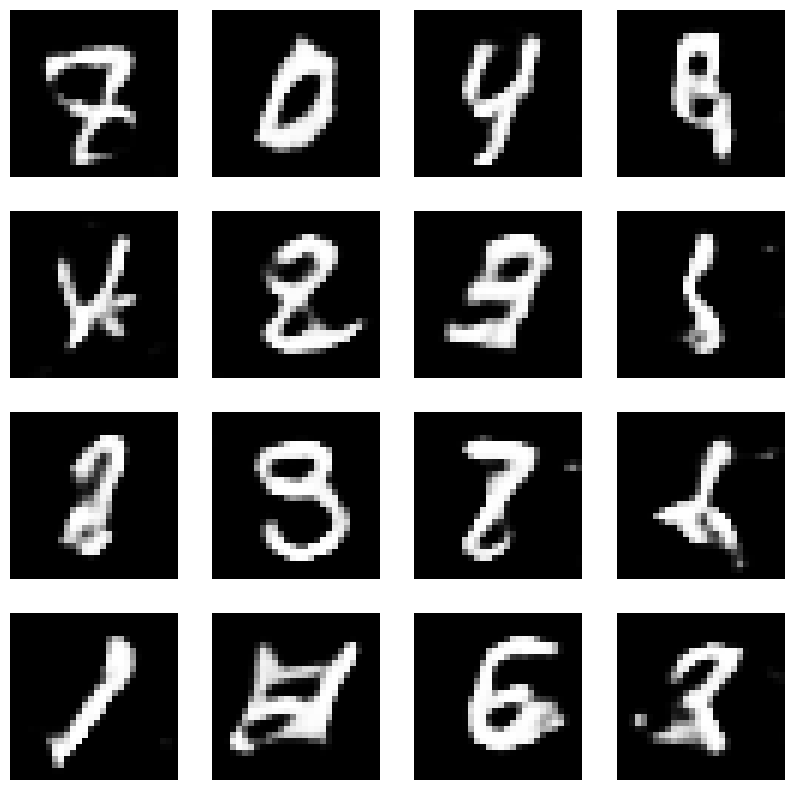

Epoch:  86


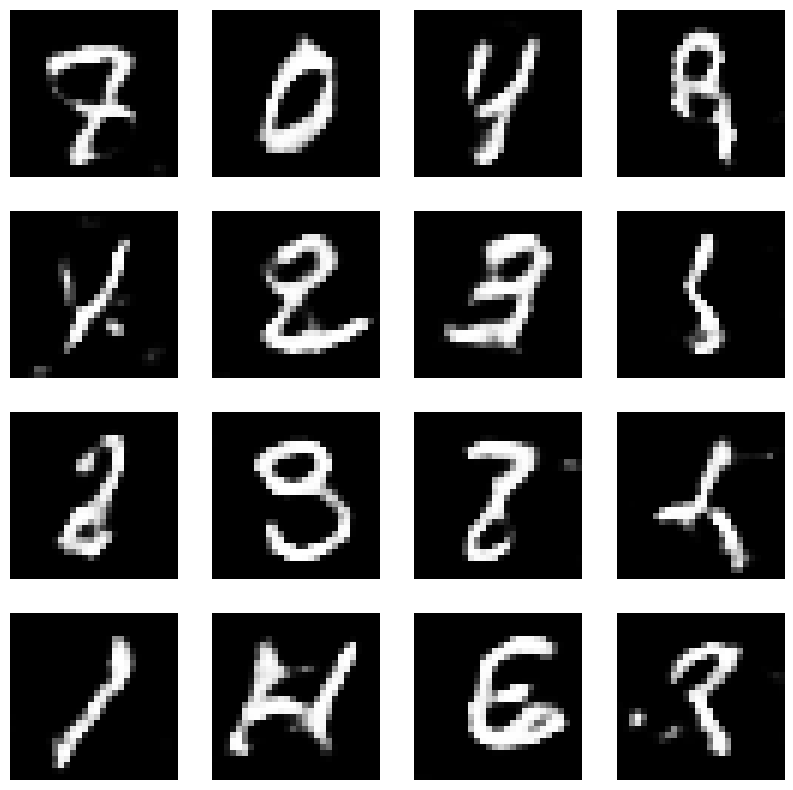

Epoch:  87


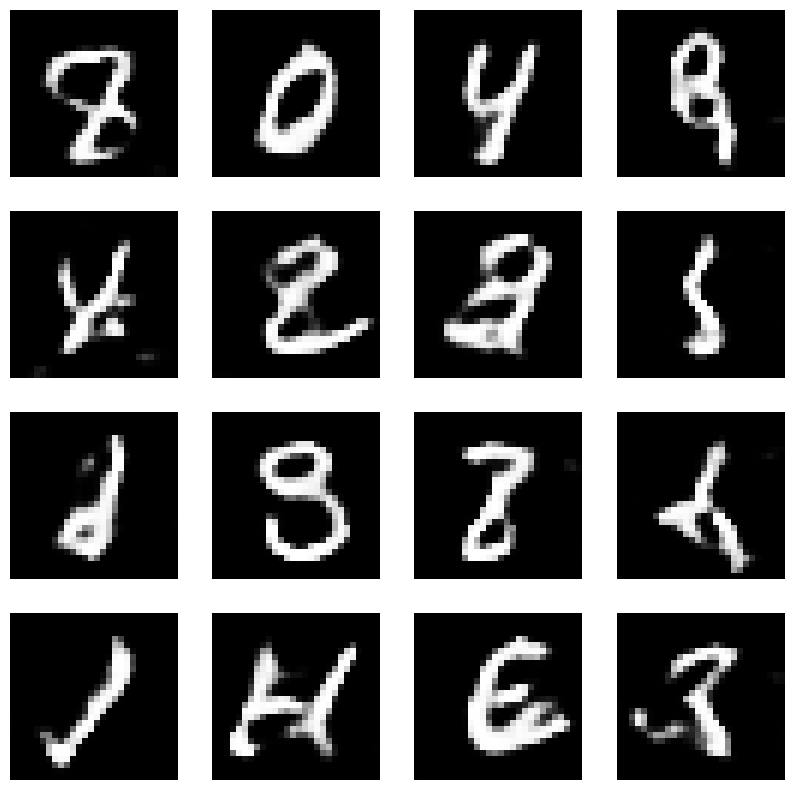

Epoch:  88


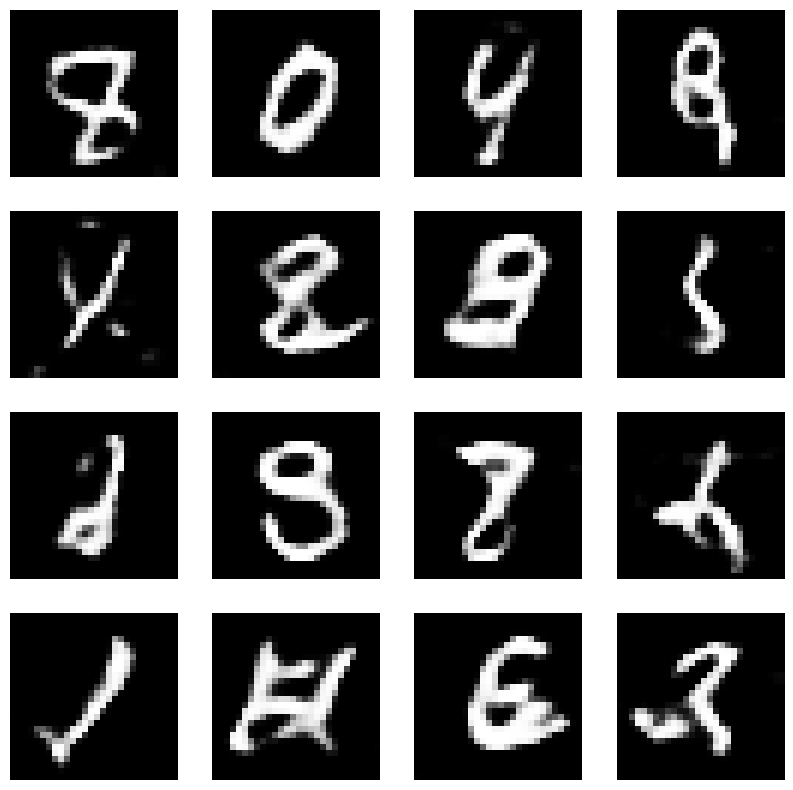

Epoch:  89


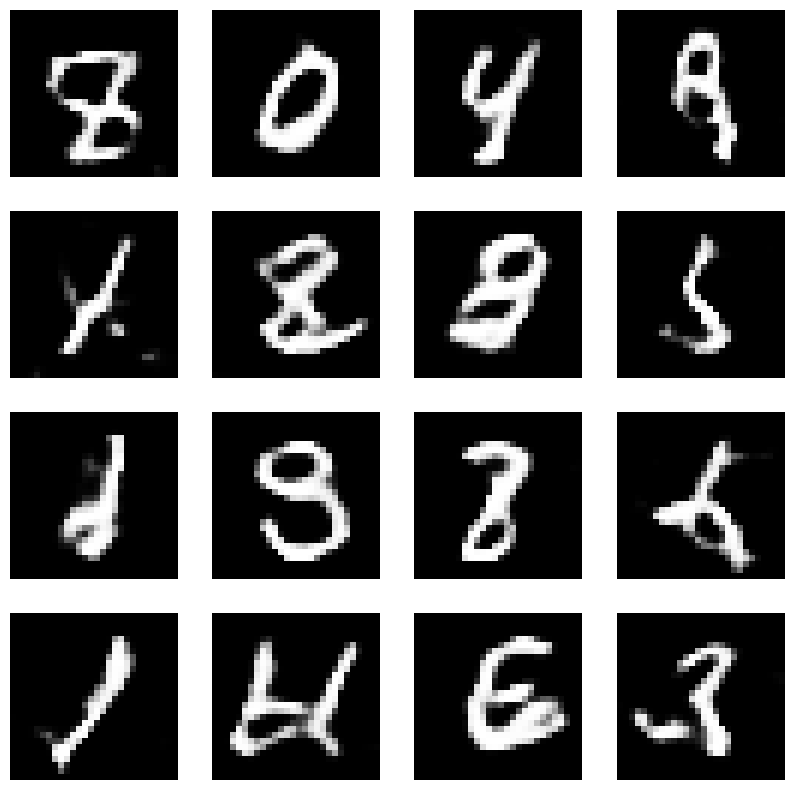

Epoch:  90


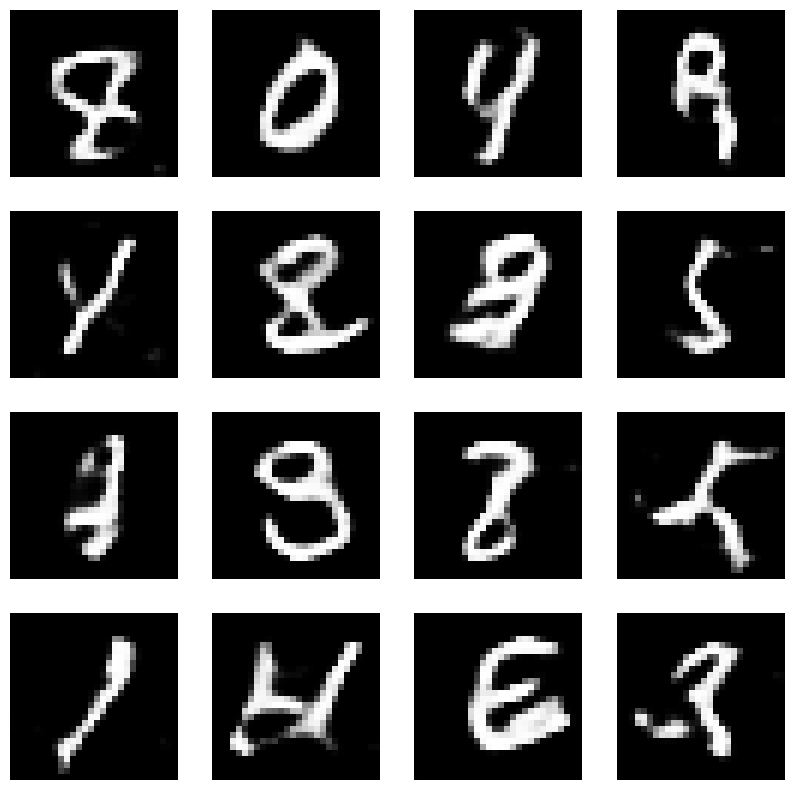

Epoch:  91


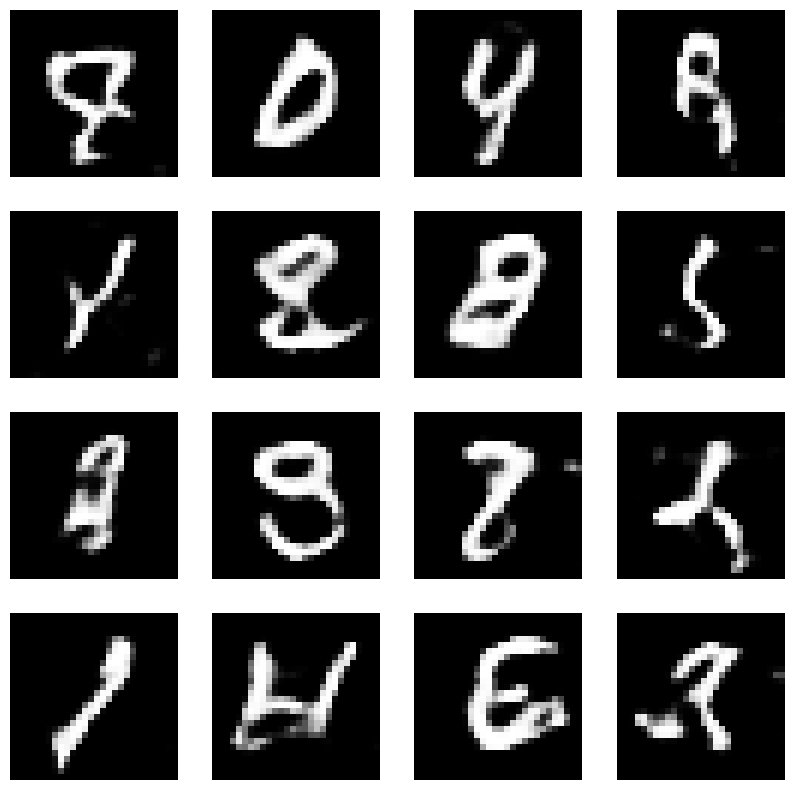

Epoch:  92


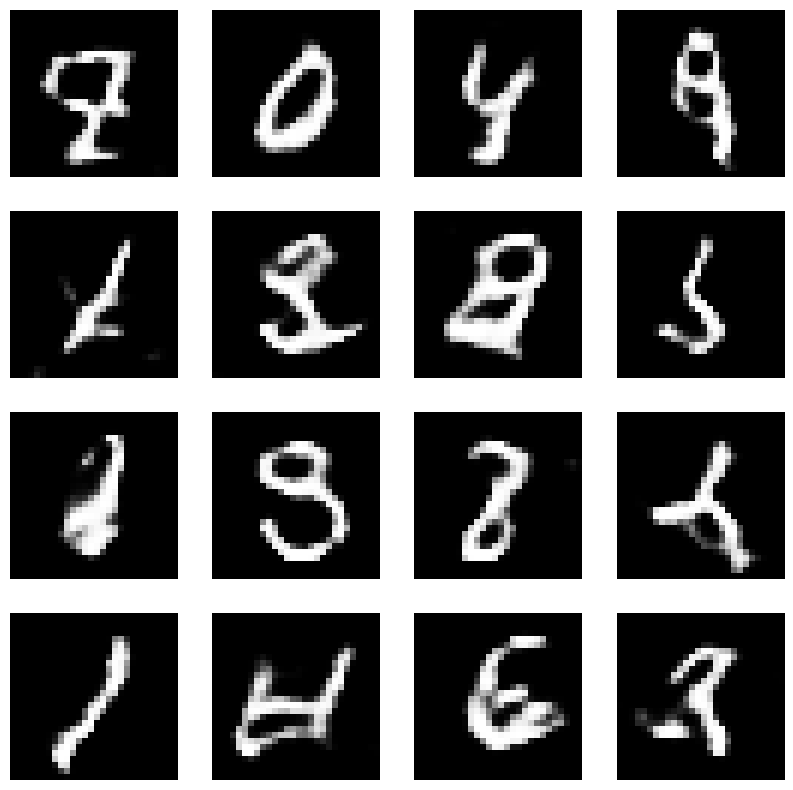

Epoch:  93


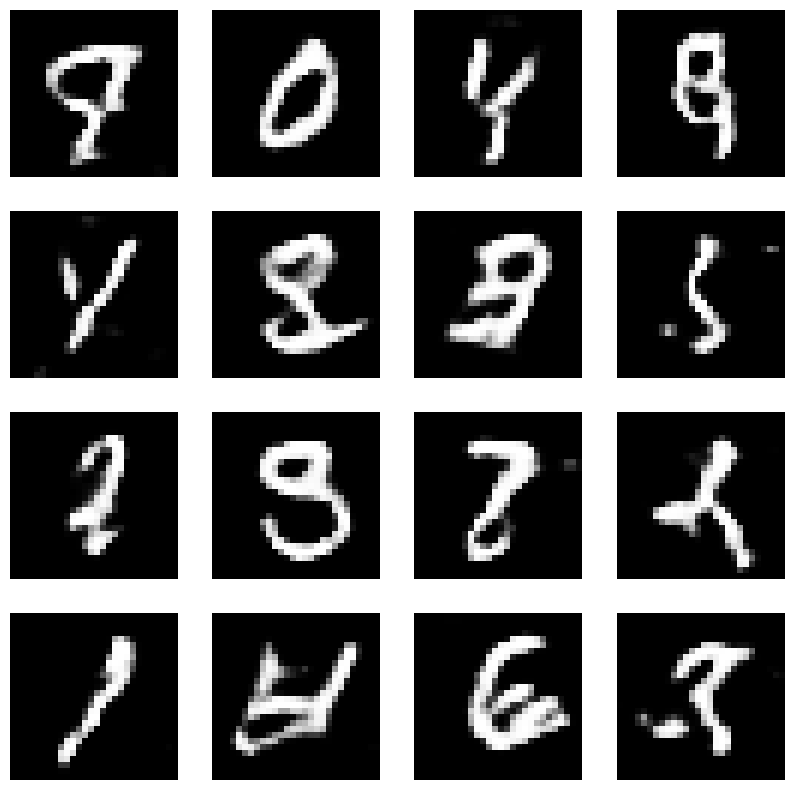

Epoch:  94


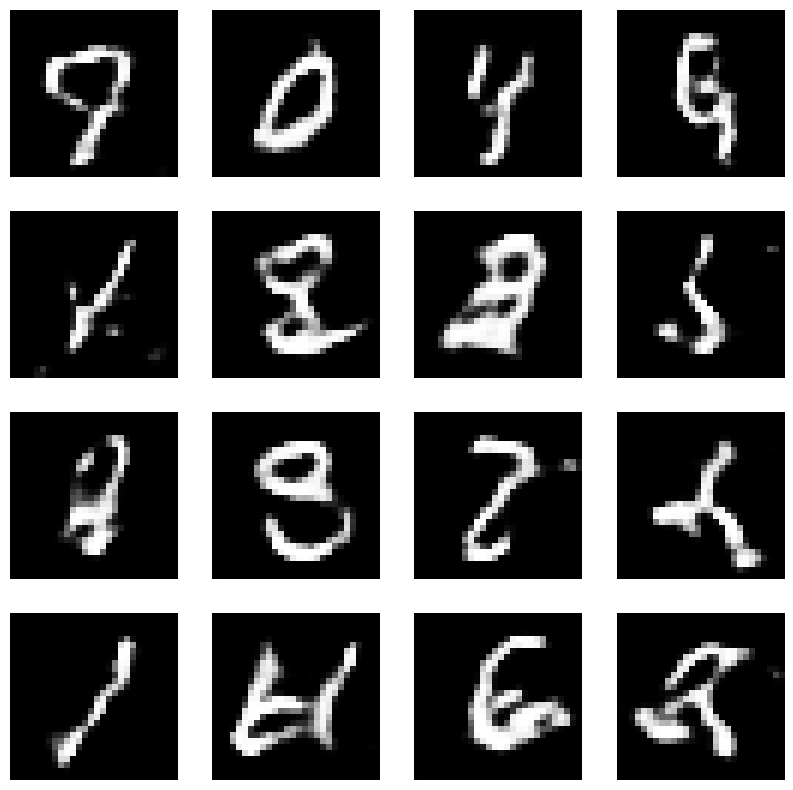

Epoch:  95


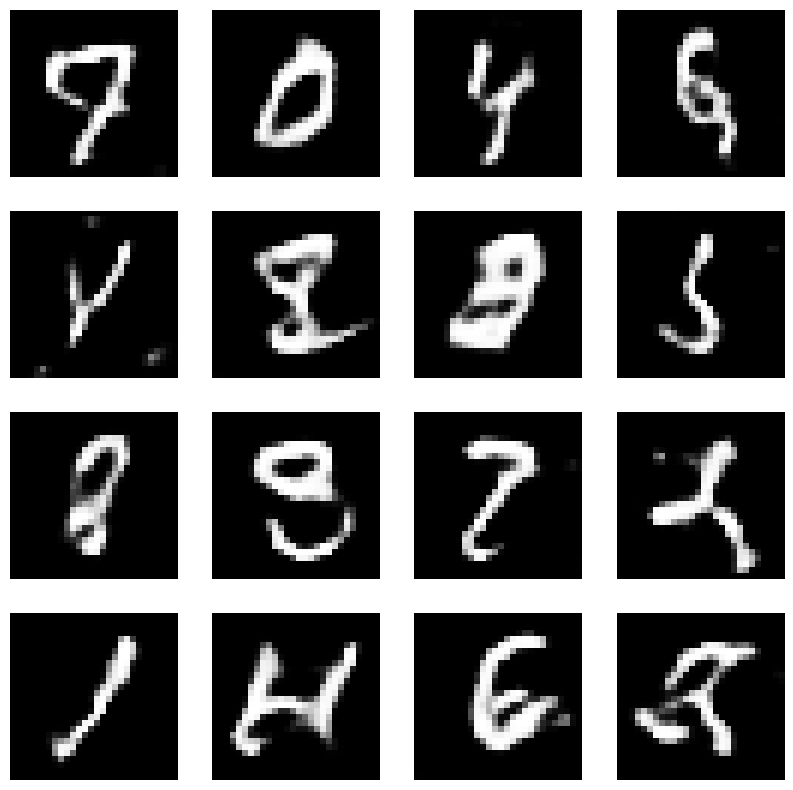

Epoch:  96


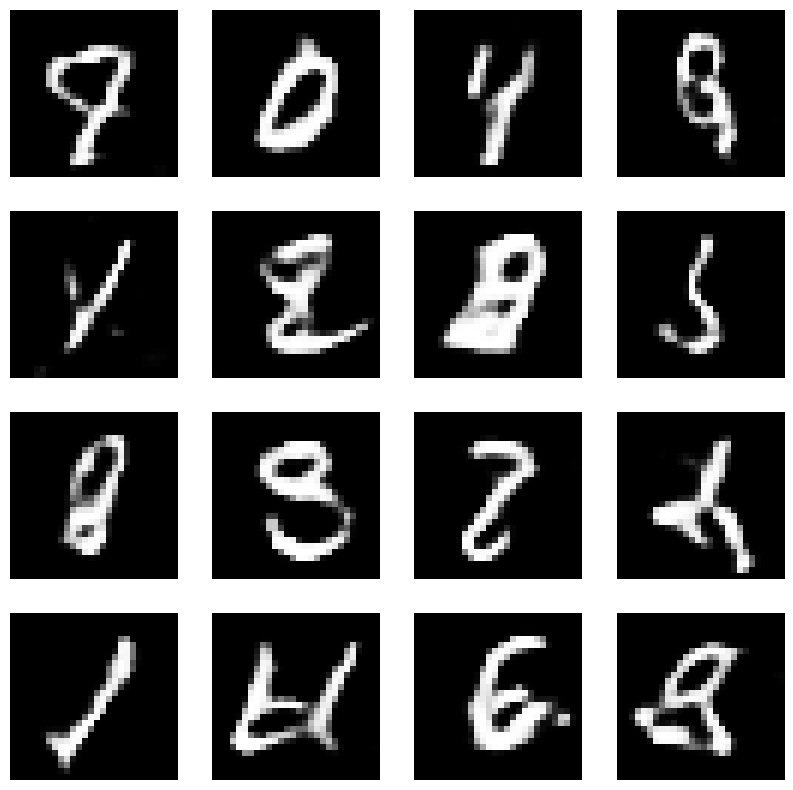

Epoch:  97


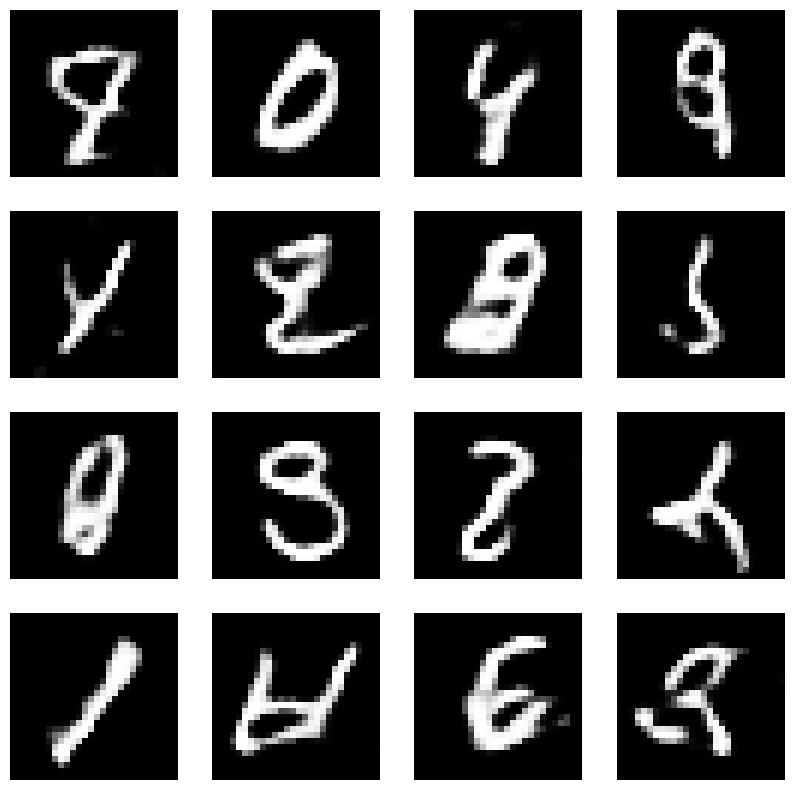

Epoch:  98


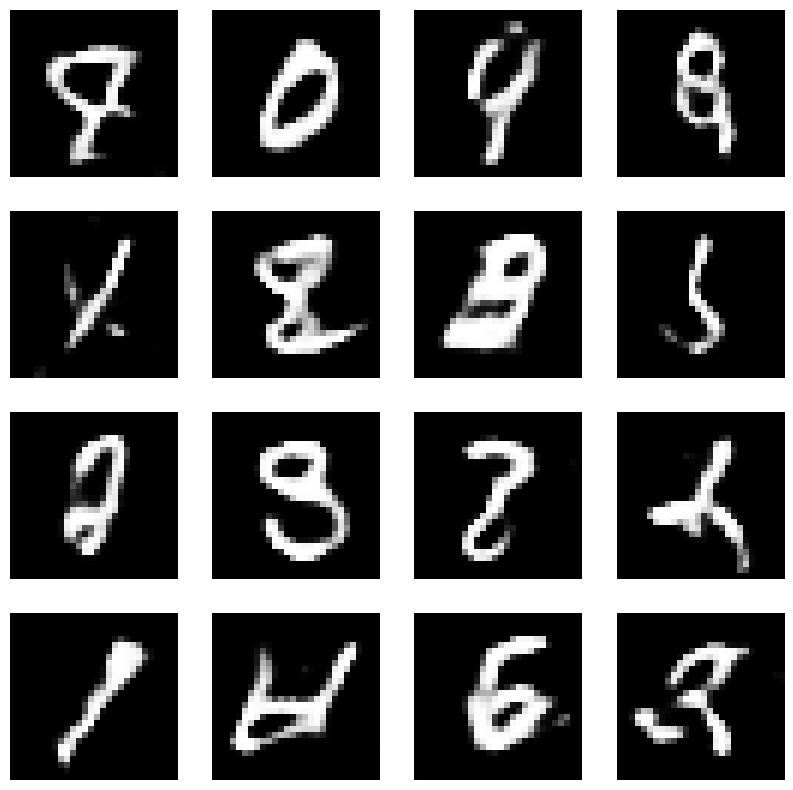

Epoch:  99


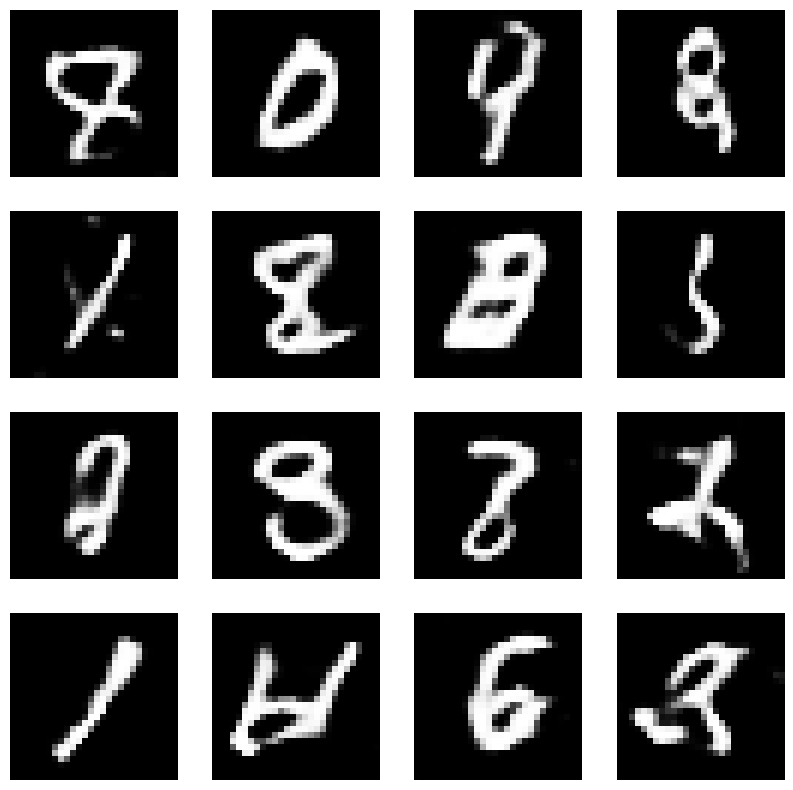

Epoch:  100


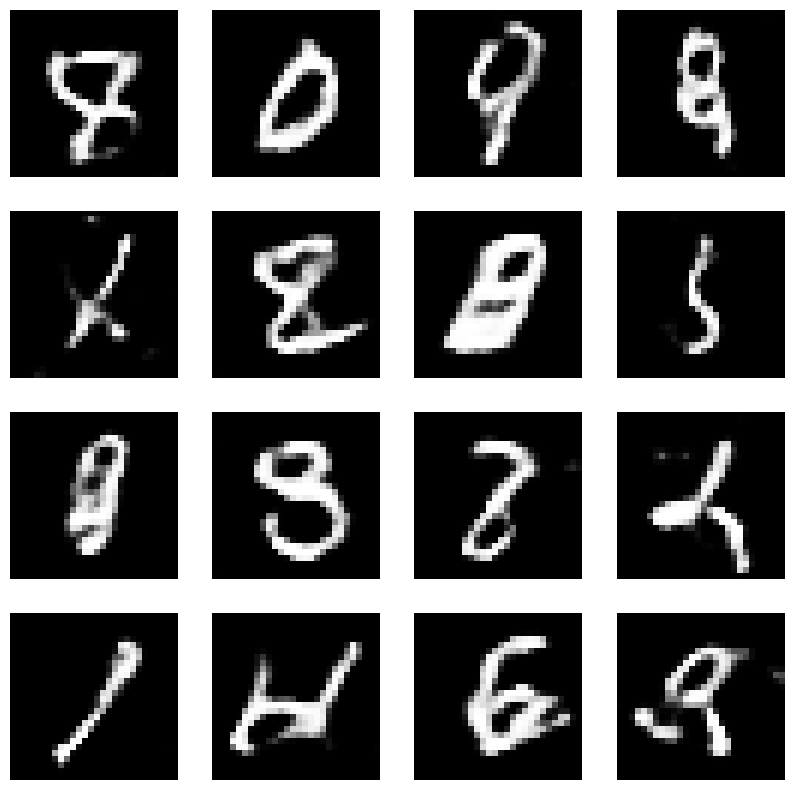

In [38]:
train_gan(X_train,epochs,test_images)